## 1. Import Dependencies

In [1]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import re
from pathlib import Path
from typing import List, Tuple, Dict
from tqdm import tqdm
import pandas as pd

# Add TRAILVISION library to path
trailvision_path = '/data/common/dataiku/config/projects/TRAILVISION/lib/python/'
if trailvision_path not in sys.path:
    sys.path.append(trailvision_path)

# Import ML libraries
import torch
from transformers import (
    Mask2FormerImageProcessor,
    Mask2FormerForUniversalSegmentation,
)
from skimage import exposure

print(f"✓ PyTorch {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  Device: {torch.cuda.get_device_name(0)}")
print("✓ All libraries imported successfully")

/data/dataiku/.conda/envs/stereo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ PyTorch 2.9.1+cu128
✓ CUDA available: True
  Device: NVIDIA RTX 6000 Ada Generation
✓ All libraries imported successfully


## 2. Configuration

In [2]:
# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Dataset paths
workspace_dir = Path("/data/common/STEREOSTUDYIPSL")
datasets_dir = workspace_dir / "Datasets"

DATASET1_NAME = "gQg5IUvV"  # IPSL dataset
DATASET2_NAME = "OdnkTZQ8"  # ECTL dataset

dataset1_dir = datasets_dir / DATASET1_NAME / "PROJECTED"
dataset2_dir = datasets_dir / DATASET2_NAME / "PROJECTED"

# Model configuration
task = "panoptic"
model_size = "base"
run_id = "polygon"

trailvision_dir = Path("/data/common/TRAILVISION")
segmentation_dir = trailvision_dir / "segmentation"
models_dir = segmentation_dir / "models"
checkpoint_dir = models_dir / task / run_id

# Histogram matching option
USE_HISTOGRAM_MATCHING = False

print(f"Dataset 1 (IPSL): {dataset1_dir}")
print(f"  Exists: {dataset1_dir.exists()}")
print(f"Dataset 2 (ECTL): {dataset2_dir}")
print(f"  Exists: {dataset2_dir.exists()}")
print(f"Model checkpoint: {checkpoint_dir}")
print(f"  Exists: {checkpoint_dir.exists()}")
print(f"\nHistogram matching: {'ENABLED' if USE_HISTOGRAM_MATCHING else 'DISABLED'}")

Dataset 1 (IPSL): /data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/PROJECTED
  Exists: True
Dataset 2 (ECTL): /data/common/STEREOSTUDYIPSL/Datasets/OdnkTZQ8/PROJECTED
  Exists: True
Model checkpoint: /data/common/TRAILVISION/segmentation/models/panoptic/polygon
  Exists: True

Histogram matching: DISABLED


## 3. Load Model and Processor

In [3]:
# Base model from Hugging Face
# base_model = f"facebook/mask2former-swin-{model_size}-coco-{task}"
base_model = "/data/common/STEREOSTUDYIPSL/Codebase/FineTuning/contrail_segmentation"

# Define categories
categories = [
    {"id": 1, "name": "contrail", "isthing": 1, "color": [255, 0, 0]},
]
if task == "panoptic":
    background_category_id = len(categories) + 1
    categories.append(
        {
            "id": background_category_id,
            "name": "sky",
            "isthing": 0,
            "color": [135, 206, 235],
        }
    )

# Create id2label mapping
id2label = {id: label["name"] for id, label in enumerate(categories)}
print(f"Categories: {id2label}")

# Image processor
processor = Mask2FormerImageProcessor.from_pretrained(
    base_model,
    do_resize=False,
    do_rescale=False,
    do_normalize=True,
    do_reduce_labels=True,
    ignore_index=255,
)

print("✓ Processor loaded")

# Load model
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint_dir,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"✓ Model loaded on {device}")
print(f"  Model classes: {model.config.num_labels}")

Categories: {0: 'contrail', 1: 'sky'}
✓ Processor loaded
✓ Model loaded on cuda
  Model classes: 2


## 4. Load and Check Datasets

In [4]:
# Find all projected images
dataset1_images = sorted(list(dataset1_dir.glob('*.jpg')))
dataset2_images = sorted(list(dataset2_dir.glob('*.jpg')))

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Dataset 1 (IPSL - {DATASET1_NAME}): {len(dataset1_images)} images")
if len(dataset1_images) > 0:
    print(f"  First: {dataset1_images[0].name}")
    print(f"  Last:  {dataset1_images[-1].name}")

print(f"\nDataset 2 (ECTL - {DATASET2_NAME}): {len(dataset2_images)} images")
if len(dataset2_images) > 0:
    print(f"  First: {dataset2_images[0].name}")
    print(f"  Last:  {dataset2_images[-1].name}")
print("="*60)

DATASET SUMMARY
Dataset 1 (IPSL - gQg5IUvV): 323 images
  First: 20250406044600_01.jpg
  Last:  20250406153000_01.jpg

Dataset 2 (ECTL - OdnkTZQ8): 1441 images
  First: image_20250406050000.jpg
  Last:  image_20250406170000.jpg


## 5. Timestamp Matching Functions

In [5]:
def extract_timestamp_from_ipsl(filename: str) -> datetime.datetime:
    """
    Extract timestamp from IPSL filename format: YYYYMMDDHHMMSS_XX.jpg
    """
    match = re.search(r'(\d{14})', filename)
    if match:
        timestamp_str = match.group(1)
        return datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return None

def extract_timestamp_from_ectl(filename: str) -> datetime.datetime:
    """
    Extract timestamp from ECTL filename format: image_YYYYMMDDHHMMSS.jpg
    """
    match = re.search(r'image_(\d{14})', filename)
    if match:
        timestamp_str = match.group(1)
        return datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return None

def find_matching_image_pairs(dataset1_images: List[Path], dataset2_images: List[Path]) -> List[Dict]:
    """
    Find image pairs with matching timestamps.
    
    Returns:
        List of dictionaries with matched pairs
    """
    # Parse timestamps for both datasets
    dataset1_parsed = []
    for img_path in dataset1_images:
        timestamp = extract_timestamp_from_ipsl(img_path.name)
        if timestamp:
            dataset1_parsed.append({
                'path': img_path,
                'timestamp': timestamp,
                'filename': img_path.name
            })
    
    dataset2_parsed = []
    for img_path in dataset2_images:
        timestamp = extract_timestamp_from_ectl(img_path.name)
        if timestamp:
            dataset2_parsed.append({
                'path': img_path,
                'timestamp': timestamp,
                'filename': img_path.name
            })
    
    # Find exact matches
    matched_pairs = []
    for item1 in dataset1_parsed:
        for item2 in dataset2_parsed:
            if item1['timestamp'] == item2['timestamp']:
                matched_pairs.append({
                    'ipsl_path': item1['path'],
                    'ipsl_filename': item1['filename'],
                    'ectl_path': item2['path'],
                    'ectl_filename': item2['filename'],
                    'timestamp': item1['timestamp']
                })
                break
    
    return matched_pairs

print("✓ Timestamp matching functions defined")

✓ Timestamp matching functions defined


## 6. Find Matched Image Pairs

In [7]:
print("Finding matched image pairs...")
matched_pairs = find_matching_image_pairs(dataset1_images, dataset2_images)

print(f"\n✓ Found {len(matched_pairs)} matched image pairs")

# Filter pairs to only include images from 7am to 8am
print("\nFiltering for images between 7:00 AM and 8:00 AM...")
filtered_pairs = []
for pair in matched_pairs:
    hour = pair['timestamp'].hour
    if 11 <= hour < 15:
        filtered_pairs.append(pair)

matched_pairs = filtered_pairs
print(f"✓ {len(matched_pairs)} pairs in 1-3pm time window")
if len(matched_pairs) > 0:
    print("\nFirst 5 matched pairs:")
    for i, pair in enumerate(matched_pairs[:5]):
        print(f"\nPair {i+1}:")
        print(f"  Timestamp: {pair['timestamp']}")
        print(f"  IPSL: {pair['ipsl_filename']}")
        print(f"  ECTL: {pair['ectl_filename']}")
else:
    print("\n⚠ No matched pairs found in the 7-8am time window!")

Finding matched image pairs...

✓ Found 316 matched image pairs

Filtering for images between 7:00 AM and 8:00 AM...
✓ 120 pairs in 1-3pm time window

First 5 matched pairs:

Pair 1:
  Timestamp: 2025-04-06 11:00:00
  IPSL: 20250406110000_01.jpg
  ECTL: image_20250406110000.jpg

Pair 2:
  Timestamp: 2025-04-06 11:02:00
  IPSL: 20250406110200_01.jpg
  ECTL: image_20250406110200.jpg

Pair 3:
  Timestamp: 2025-04-06 11:04:00
  IPSL: 20250406110400_01.jpg
  ECTL: image_20250406110400.jpg

Pair 4:
  Timestamp: 2025-04-06 11:06:00
  IPSL: 20250406110600_01.jpg
  ECTL: image_20250406110600.jpg

Pair 5:
  Timestamp: 2025-04-06 11:08:00
  IPSL: 20250406110800_01.jpg
  ECTL: image_20250406110800.jpg


## 7. Histogram Matching Functions

In [8]:
def match_histogram(source_image: np.ndarray, reference_image: np.ndarray) -> np.ndarray:
    """
    Match the histogram of source image to reference image.
    
    Args:
        source_image: Image to transform (RGB numpy array)
        reference_image: Reference image with target histogram (RGB numpy array)
        
    Returns:
        Histogram-matched image
    """
    matched = exposure.match_histograms(source_image, reference_image, channel_axis=2)
    return matched.astype(np.uint8)

print("✓ Histogram matching function defined")

✓ Histogram matching function defined


## 8. Inference Function

In [9]:
def run_inference(image: np.ndarray, threshold=0.5, mask_threshold=0.5, overlap_threshold=0.8):
    """
    Run segmentation inference on an image.
    
    Args:
        image: RGB image as numpy array
        
    Returns:
        Segmentation results
    """
    # Prepare inputs
    inputs = processor([image], return_tensors="pt").to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process
    target_sizes = [image.shape[:2]]
    
    if task == "panoptic":
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
        }
        segmentation = processor.post_process_panoptic_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    else:
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
            "return_binary_maps": True,
        }
        segmentation = processor.post_process_instance_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    
    return segmentation

print("✓ Inference function defined")

✓ Inference function defined


## 9. Side-by-Side Visualization Function

In [10]:
def visualize_inference_pair(ipsl_image, ectl_image, ipsl_seg, ectl_seg, 
                            ipsl_filename, ectl_filename, timestamp,
                            histogram_matched=False):
    """
    Visualize inference results for a matched pair.
    
    Args:
        ipsl_image: IPSL image (numpy array)
        ectl_image: ECTL image (numpy array)
        ipsl_seg: IPSL segmentation results
        ectl_seg: ECTL segmentation results
        ipsl_filename: IPSL filename
        ectl_filename: ECTL filename
        timestamp: Image timestamp
        histogram_matched: Whether histogram matching was applied
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 20))
    
    # Row 1: Original images
    axes[0, 0].imshow(ipsl_image)
    title1 = f"IPSL\n{ipsl_filename}"
    if histogram_matched:
        title1 += "\n[Histogram Matched]"
    axes[0, 0].set_title(title1, fontsize=10)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ectl_image)
    axes[0, 1].set_title(f"ECTL\n{ectl_filename}", fontsize=10)
    axes[0, 1].axis('off')
    
    # Row 2: Segmentation masks
    if 'segmentation' in ipsl_seg:
        ipsl_mask = ipsl_seg['segmentation'].cpu().numpy()
        axes[1, 0].imshow(ipsl_mask, cmap='tab20')
        axes[1, 0].set_title('IPSL Segmentation Mask', fontsize=10)
        axes[1, 0].axis('off')
    
    if 'segmentation' in ectl_seg:
        ectl_mask = ectl_seg['segmentation'].cpu().numpy()
        axes[1, 1].imshow(ectl_mask, cmap='tab20')
        axes[1, 1].set_title('ECTL Segmentation Mask', fontsize=10)
        axes[1, 1].axis('off')
    
    # Row 3: Overlays
    if 'segmentation' in ipsl_seg:
        axes[2, 0].imshow(ipsl_image)
        axes[2, 0].imshow(ipsl_mask, alpha=0.5, cmap='tab20')
        axes[2, 0].set_title('IPSL Overlay', fontsize=10)
        axes[2, 0].axis('off')
    
    if 'segmentation' in ectl_seg:
        axes[2, 1].imshow(ectl_image)
        axes[2, 1].imshow(ectl_mask, alpha=0.5, cmap='tab20')
        axes[2, 1].set_title('ECTL Overlay', fontsize=10)
        axes[2, 1].axis('off')
    
    plt.suptitle(f"Timestamp: {timestamp}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

✓ Visualization function defined


## 10. Statistics Extraction Function

In [11]:
def extract_statistics(segmentation, label_name='contrail'):
    """
    Extract statistics from segmentation results.
    
    Returns:
        Dictionary with statistics
    """
    stats = {
        'total_segments': 0,
        'contrail_segments': 0,
        'total_pixels': 0,
        'contrail_pixels': 0,
    }
    
    if 'segments_info' not in segmentation:
        return stats
    
    segments_info = segmentation['segments_info']
    stats['total_segments'] = len(segments_info)
    
    # Count contrail segments and pixels
    if 'segmentation' in segmentation:
        seg_mask = segmentation['segmentation'].cpu().numpy()
        stats['total_pixels'] = seg_mask.size
        
        for seg_info in segments_info:
            label_id = seg_info['label_id']
            if id2label.get(label_id, '') == label_name:
                stats['contrail_segments'] += 1
                # Count pixels for this segment
                segment_id = seg_info['id']
                stats['contrail_pixels'] += np.sum(seg_mask == segment_id)
    
    return stats

print("✓ Statistics extraction function defined")

✓ Statistics extraction function defined


## Image Preprocessing

In [12]:
import numpy as np
import cv2  # pip install opencv-python

def match_right_look(
    img: np.ndarray,
    *,
    input="bgr",        # "bgr" or "rgb"
    cool=0,          # 0..0.4  : cooler WB (more blue, less red)
    exposure=-0.10,     # stops   : negative darkens
    contrast=0.35,      # 0..0.5  : gentle S-curve strength
    hl=-0.55,           # -1..0   : highlight compression
    dehaze=0,        # 0..0.3  : haze reduction + structure
    clarity=0.1,       # 0..0.3  : local contrast
    sat=0,          # -0.3..0.3: global saturation change
) -> np.ndarray:
    """
    Push an image toward a cooler, deeper, highlight-controlled look.
    Accepts uint8 or float images; returns float32 if input was float, else uint8.
    """
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Expected HxWx3 image")

    in_dtype = img.dtype
    is_float_in = np.issubdtype(in_dtype, np.floating)

    # Normalize to float32 in 0..1 for processing (prevents cvtColor CV_64F issues)
    x = img.astype(np.float32)
    if not is_float_in:
        x /= 255.0
    else:
        if x.max() > 1.5:  # float but 0..255-ish
            x /= 255.0

    if input.lower() == "rgb":
        x = x[..., ::-1]  # to BGR for OpenCV ops

    # WB cooling: scale R down, B up (key)
    x[..., 2] *= (1.0 - 0.9 * cool)   # R
    x[..., 0] *= (1.0 + 0.9 * cool)   # B

    # Exposure
    x *= (2.0 ** exposure)

    # Highlight roll-off (key): compress bright halo
    lum = (0.114 * x[..., 0] + 0.587 * x[..., 1] + 0.299 * x[..., 2])
    w = np.clip((lum - 0.55) / 0.45, 0.0, 1.0) ** 2.0
    x = x + hl * w[..., None] * (x - 1.0)  # hl negative pulls highlights down

    # Global contrast (gentle S-curve)
    if contrast != 0:
        k = 1.0 + 4.0 * contrast
        x = 1.0 / (1.0 + np.exp(-k * (x - 0.5)))
        y0 = 1.0 / (1.0 + np.exp(-k * (0.0 - 0.5)))
        y1 = 1.0 / (1.0 + np.exp(-k * (1.0 - 0.5)))
        x = (x - y0) / (y1 - y0 + 1e-6)

    # Dehaze (moderate): subtract small airlight estimate + tiny contrast bump
    if dehaze != 0:
        minc = np.min(x, axis=2)
        air = cv2.GaussianBlur(minc, (0, 0), 25)[..., None]
        x = x - (0.12 * dehaze) * w[..., None] * air
        k2 = 1.0 + 2.5 * dehaze
        x = 1.0 / (1.0 + np.exp(-k2 * (x - 0.5)))

    # Clarity: local contrast
    if clarity != 0:
        blur = cv2.GaussianBlur(x, (0, 0), 6.0)
        x = x + clarity * (x - blur)

    # Saturation in HSV (must be float32 for cv2)
    if sat != 0:
        hsv = cv2.cvtColor(np.clip(x, 0, 1).astype(np.float32), cv2.COLOR_BGR2HSV)
        hsv[..., 1] = np.clip(hsv[..., 1] * (1.0 + sat), 0.0, 1.0)
        x = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    x = np.clip(x, 0.0, 1.0)

    if input.lower() == "rgb":
        x = x[..., ::-1]  # back to RGB

    # Return same "kind" as input
    if is_float_in:
        return x.astype(np.float32)
    return (x * 255.0 + 0.5).astype(np.uint8)


## 11. Process Matched Pairs

Processing 2 matched pairs...
Histogram matching: DISABLED


Processing pair 1/2
Timestamp: 2025-04-06 11:00:00
  IPSL image shape: (1024, 1024, 3)
  ECTL image shape: (1024, 1024, 3) [vertically flipped]
  Running inference on IPSL image...


`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.


  Running inference on ECTL image...

  IPSL: 15 segments (14 contrails, 39544 pixels)
  ECTL: 31 segments (30 contrails, 95931 pixels)


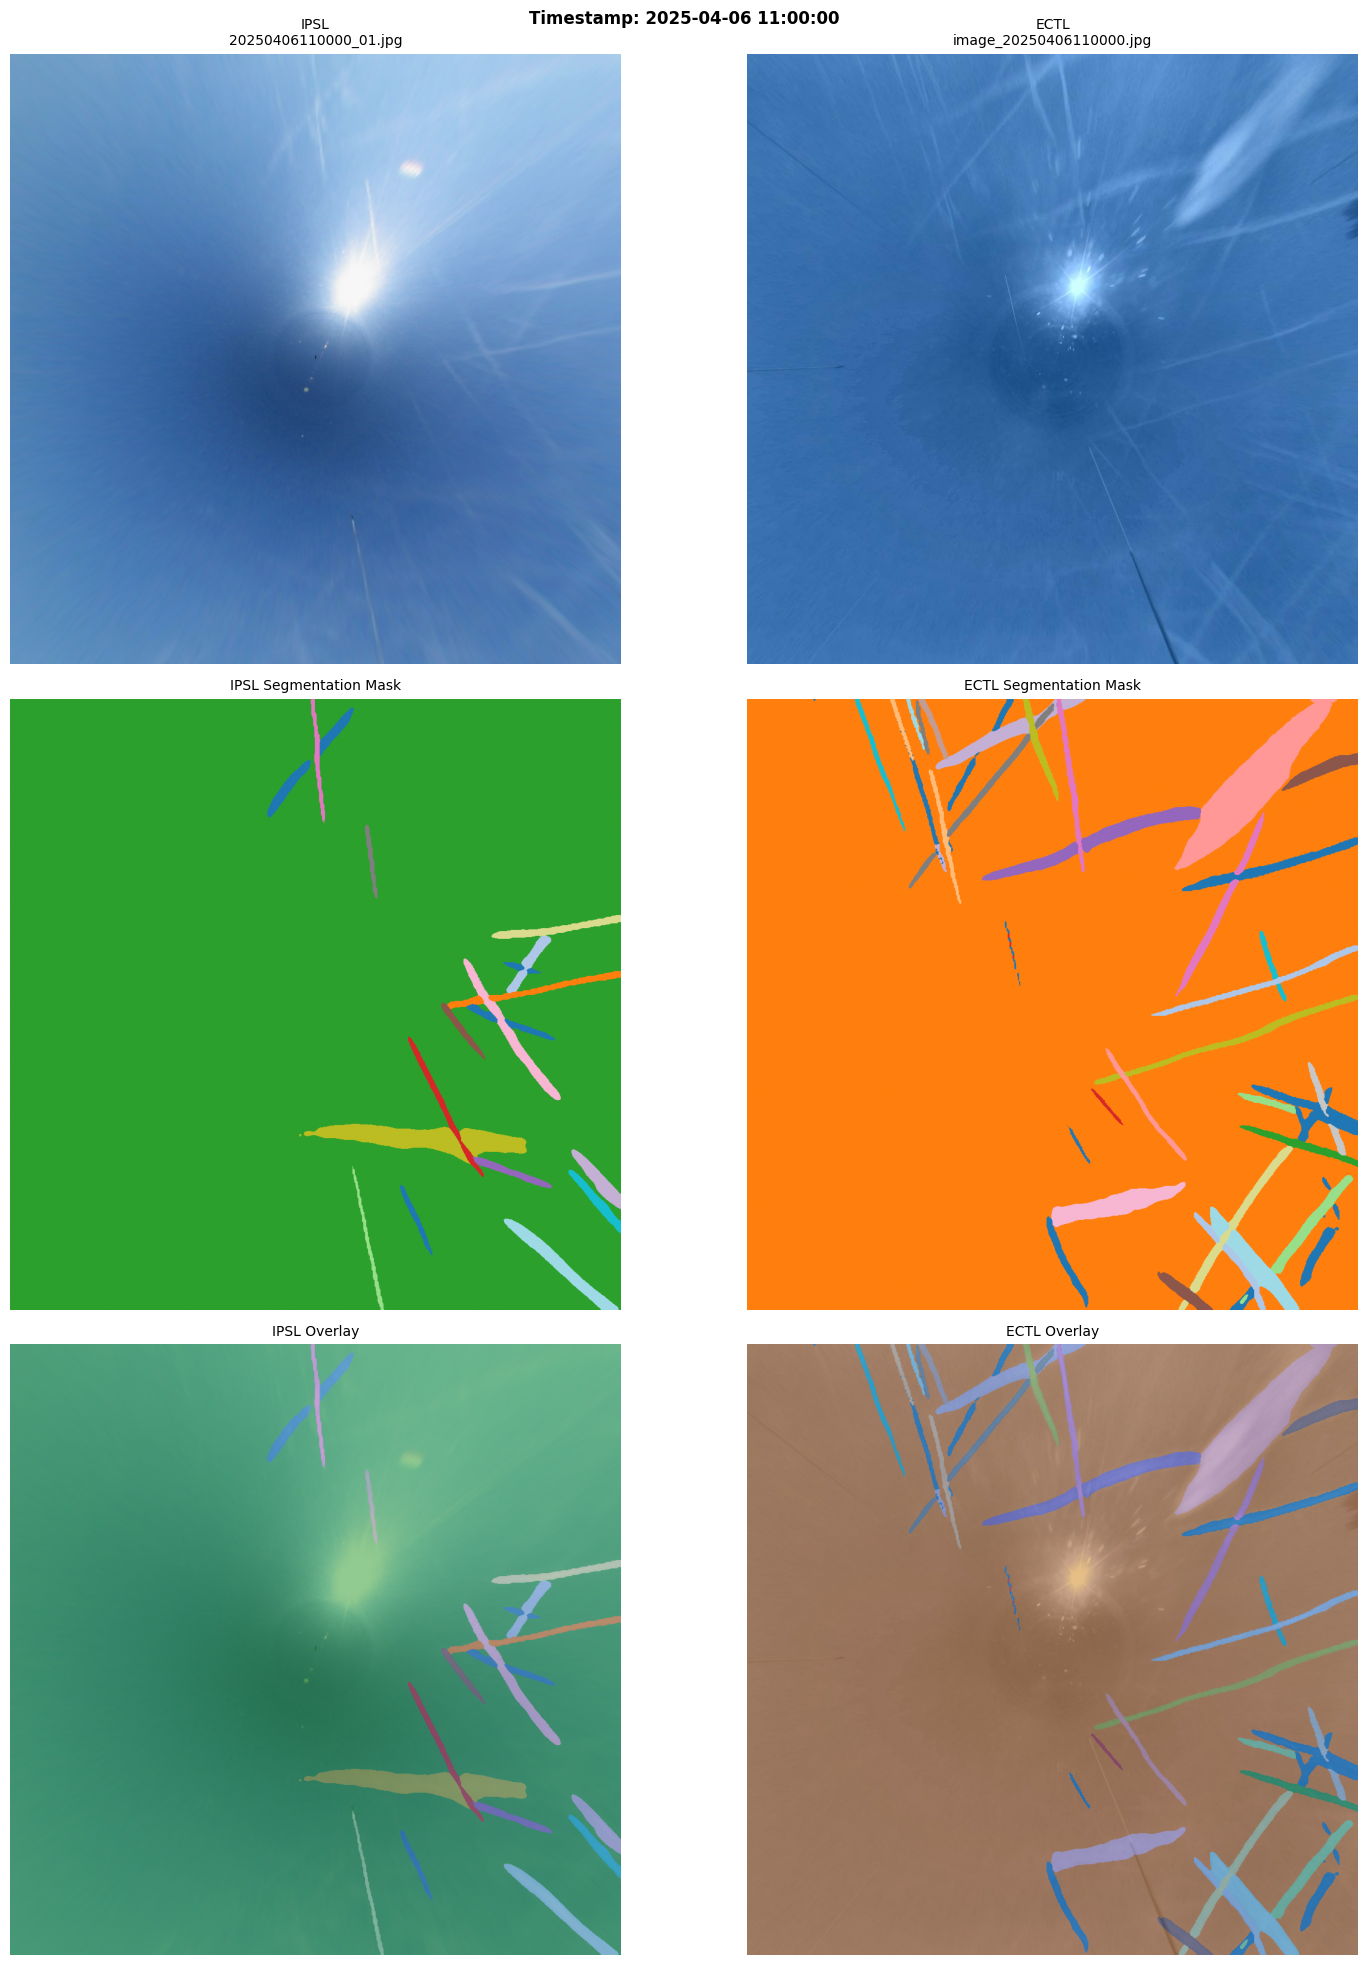


Processing pair 2/2
Timestamp: 2025-04-06 11:02:00
  IPSL image shape: (1024, 1024, 3)
  ECTL image shape: (1024, 1024, 3) [vertically flipped]
  Running inference on IPSL image...


`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.


  Running inference on ECTL image...

  IPSL: 10 segments (9 contrails, 22987 pixels)
  ECTL: 34 segments (33 contrails, 68667 pixels)


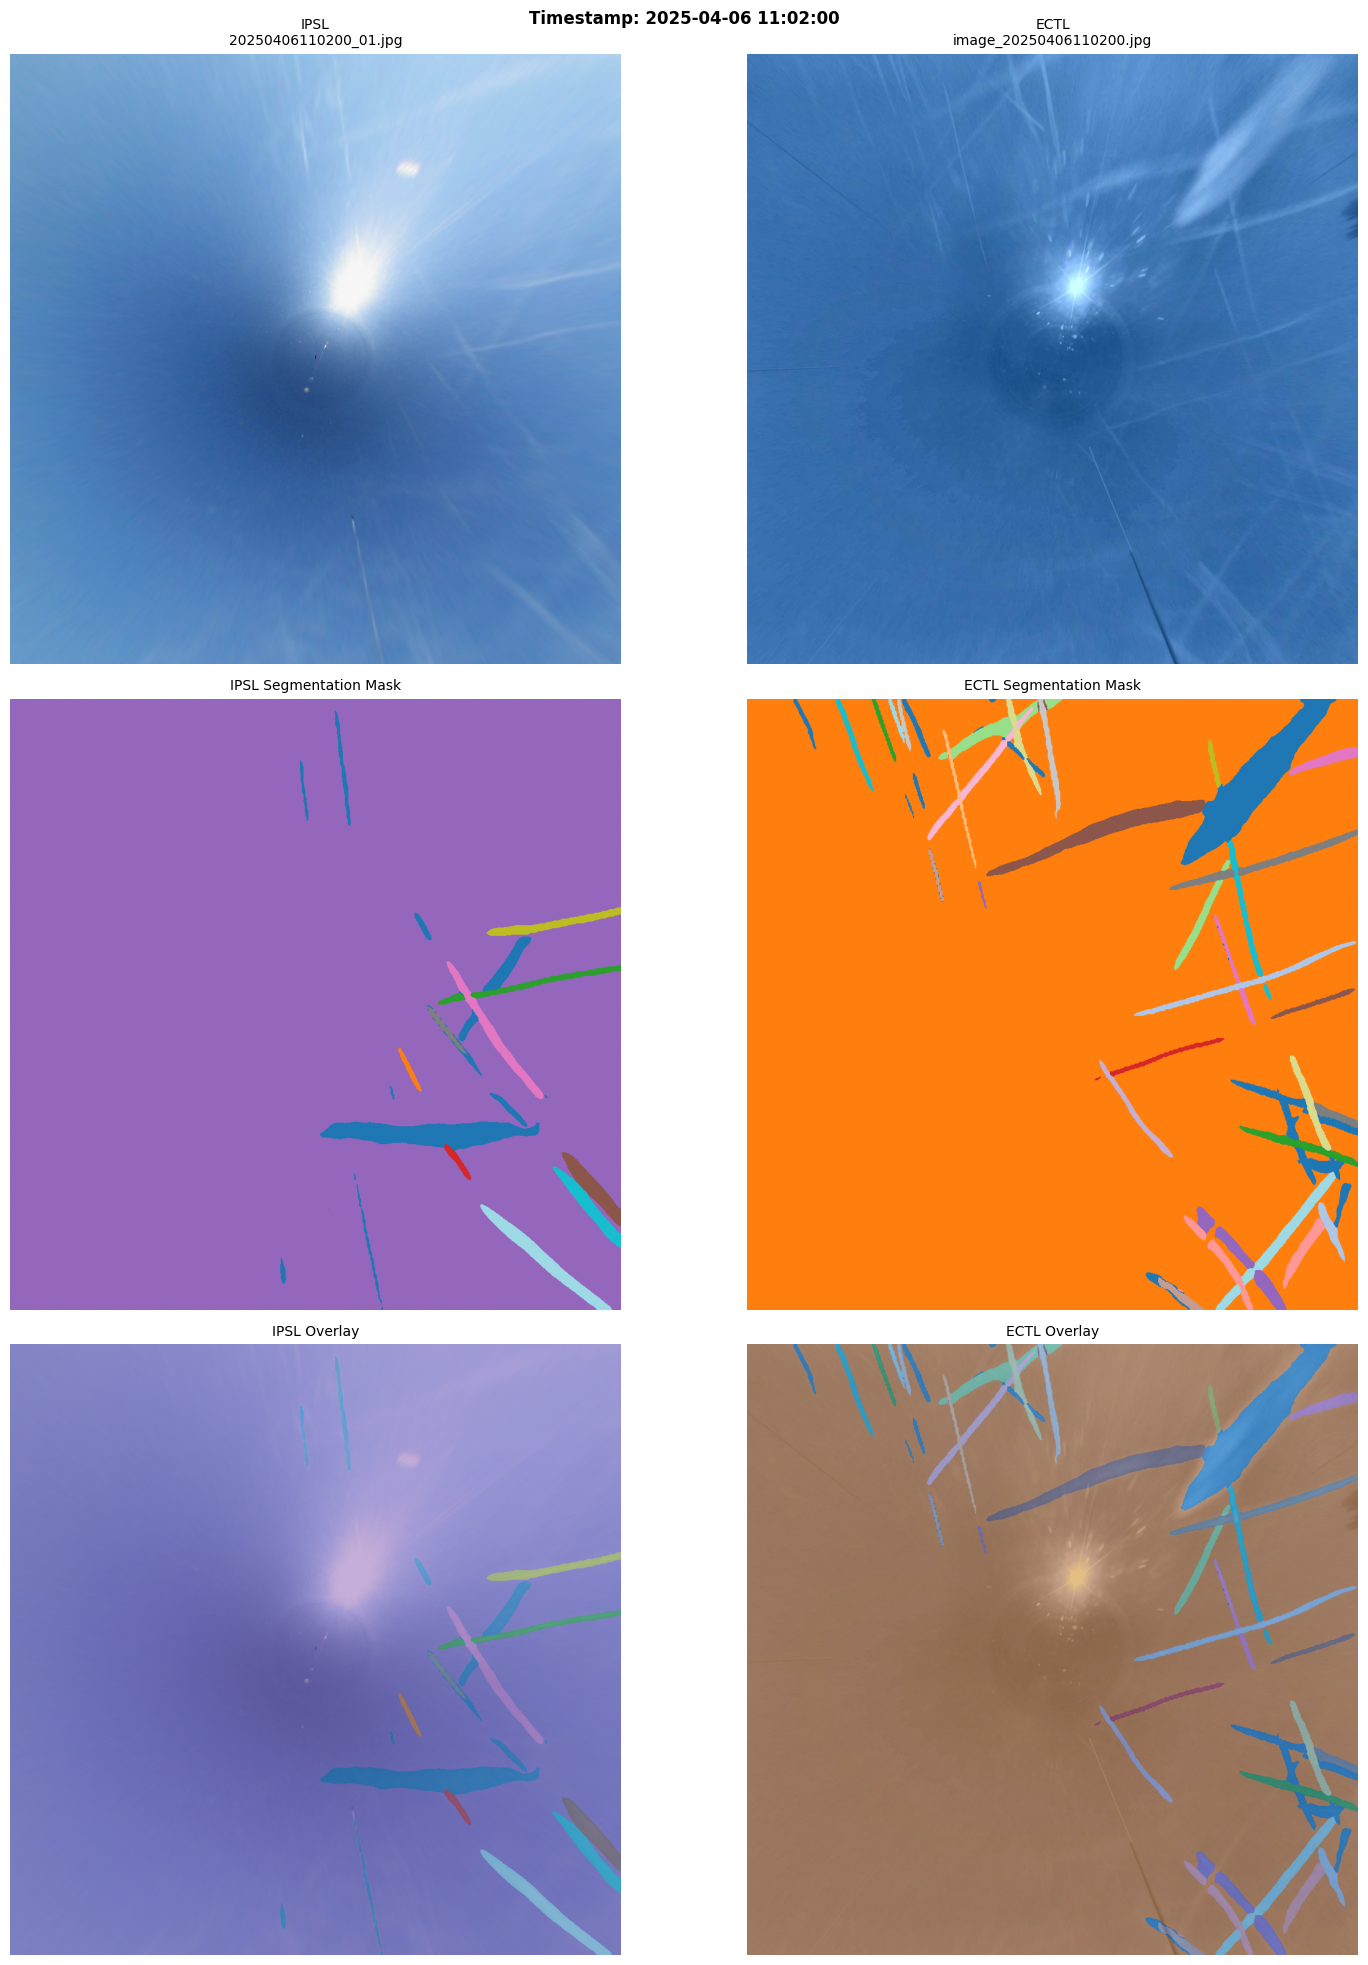


✓ Processed 2 pairs successfully


In [13]:
# Select number of pairs to process (adjust as needed)
NUM_PAIRS_TO_PROCESS = min(2, len(matched_pairs))

print(f"Processing {NUM_PAIRS_TO_PROCESS} matched pairs...")
print(f"Histogram matching: {'ENABLED' if USE_HISTOGRAM_MATCHING else 'DISABLED'}\n")

results = []

for i, pair in enumerate(matched_pairs[:NUM_PAIRS_TO_PROCESS]):
    print(f"\n{'='*80}")
    print(f"Processing pair {i+1}/{NUM_PAIRS_TO_PROCESS}")
    print(f"Timestamp: {pair['timestamp']}")
    print(f"{'='*80}")
    
    try:
        # Load images
        ipsl_image = np.array(Image.open(pair['ipsl_path']).convert('RGB'))
        ipsl_image = match_right_look(ipsl_image[..., ::-1])[..., ::-1]  # BGR to RGB with adjustments
        ectl_image = np.array(Image.open(pair['ectl_path']).convert('RGB'))
        
        # # Apply vertical flip to ECTL image
        ectl_image = np.flipud(ectl_image)
        
        print(f"  IPSL image shape: {ipsl_image.shape}")
        print(f"  ECTL image shape: {ectl_image.shape} [vertically flipped]")
        
        
        # Step 2: Apply histogram matching if enabled
        if USE_HISTOGRAM_MATCHING:
            print("  Applying histogram matching...")
            ipsl_image_processed = match_histogram(ipsl_image, ectl_image)
        else:
            ipsl_image_processed = ipsl_image.copy()
        
        # Run inference on both processed images
        print("  Running inference on IPSL image...")
        ipsl_seg = run_inference(ipsl_image_processed)
        
        print("  Running inference on ECTL image...")
        ectl_seg = run_inference(ectl_image)
        
        # Extract statistics
        ipsl_stats = extract_statistics(ipsl_seg)
        ectl_stats = extract_statistics(ectl_seg)
        
        print(f"\n  IPSL: {ipsl_stats['total_segments']} segments ({ipsl_stats['contrail_segments']} contrails, {ipsl_stats['contrail_pixels']} pixels)")
        print(f"  ECTL: {ectl_stats['total_segments']} segments ({ectl_stats['contrail_segments']} contrails, {ectl_stats['contrail_pixels']} pixels)")
        
        # Store results
        results.append({
            'timestamp': pair['timestamp'],
            'ipsl_filename': pair['ipsl_filename'],
            'ectl_filename': pair['ectl_filename'],
            'ipsl_image': ipsl_image_processed,
            'ectl_image': ectl_image,
            'ipsl_seg': ipsl_seg,
            'ectl_seg': ectl_seg,
            'ipsl_stats': ipsl_stats,
            'ectl_stats': ectl_stats,
        })
        
        # Visualize
        visualize_inference_pair(
            ipsl_image_processed, ectl_image,
            ipsl_seg, ectl_seg,
            pair['ipsl_filename'], pair['ectl_filename'],
            pair['timestamp'],
            histogram_matched=USE_HISTOGRAM_MATCHING
        )
        
    except Exception as e:
        print(f"  ✗ Error processing pair: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✓ Processed {len(results)} pairs successfully")

## 12. Comparison Table

In [14]:
if len(results) > 0:
    # Create comparison dataframe
    comparison_data = []
    
    for i, result in enumerate(results):
        comparison_data.append({
            'Pair': i + 1,
            'Timestamp': result['timestamp'].strftime('%Y-%m-%d %H:%M:%S'),
            'IPSL_Segments': result['ipsl_stats']['total_segments'],
            'IPSL_Contrails': result['ipsl_stats']['contrail_segments'],
            'IPSL_Pixels': result['ipsl_stats']['contrail_pixels'],
            'ECTL_Segments': result['ectl_stats']['total_segments'],
            'ECTL_Contrails': result['ectl_stats']['contrail_segments'],
            'ECTL_Pixels': result['ectl_stats']['contrail_pixels'],
            'Pixel_Diff': result['ipsl_stats']['contrail_pixels'] - result['ectl_stats']['contrail_pixels'],
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "="*100)
    print("COMPARISON TABLE")
    print("="*100)
    print(df_comparison.to_string(index=False))
    print("="*100)
    
    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"  Total pairs processed: {len(results)}")
    print(f"  Histogram matching: {'ENABLED' if USE_HISTOGRAM_MATCHING else 'DISABLED'}")
    print(f"\n  IPSL:")
    print(f"    Total contrail segments: {df_comparison['IPSL_Contrails'].sum()}")
    print(f"    Total contrail pixels: {df_comparison['IPSL_Pixels'].sum()}")
    print(f"    Avg contrails per image: {df_comparison['IPSL_Contrails'].mean():.2f}")
    print(f"\n  ECTL:")
    print(f"    Total contrail segments: {df_comparison['ECTL_Contrails'].sum()}")
    print(f"    Total contrail pixels: {df_comparison['ECTL_Pixels'].sum()}")
    print(f"    Avg contrails per image: {df_comparison['ECTL_Contrails'].mean():.2f}")
    
else:
    print("No results to display")


COMPARISON TABLE
 Pair           Timestamp  IPSL_Segments  IPSL_Contrails  IPSL_Pixels  ECTL_Segments  ECTL_Contrails  ECTL_Pixels  Pixel_Diff
    1 2025-04-06 11:00:00             15              14        39544             31              30        95931      -56387
    2 2025-04-06 11:02:00             10               9        22987             34              33        68667      -45680

SUMMARY STATISTICS:
  Total pairs processed: 2
  Histogram matching: DISABLED

  IPSL:
    Total contrail segments: 23
    Total contrail pixels: 62531
    Avg contrails per image: 11.50

  ECTL:
    Total contrail segments: 63
    Total contrail pixels: 164598
    Avg contrails per image: 31.50


## 14. Load SIRTA Azimuth-Zenith Calibration Map

✓ Loaded SIRTA calibration map
  Shape: (768, 1024)
  Azimuth range: [-3.1, 3.1] rad
  Zenith range: [0.0, 2.4] rad


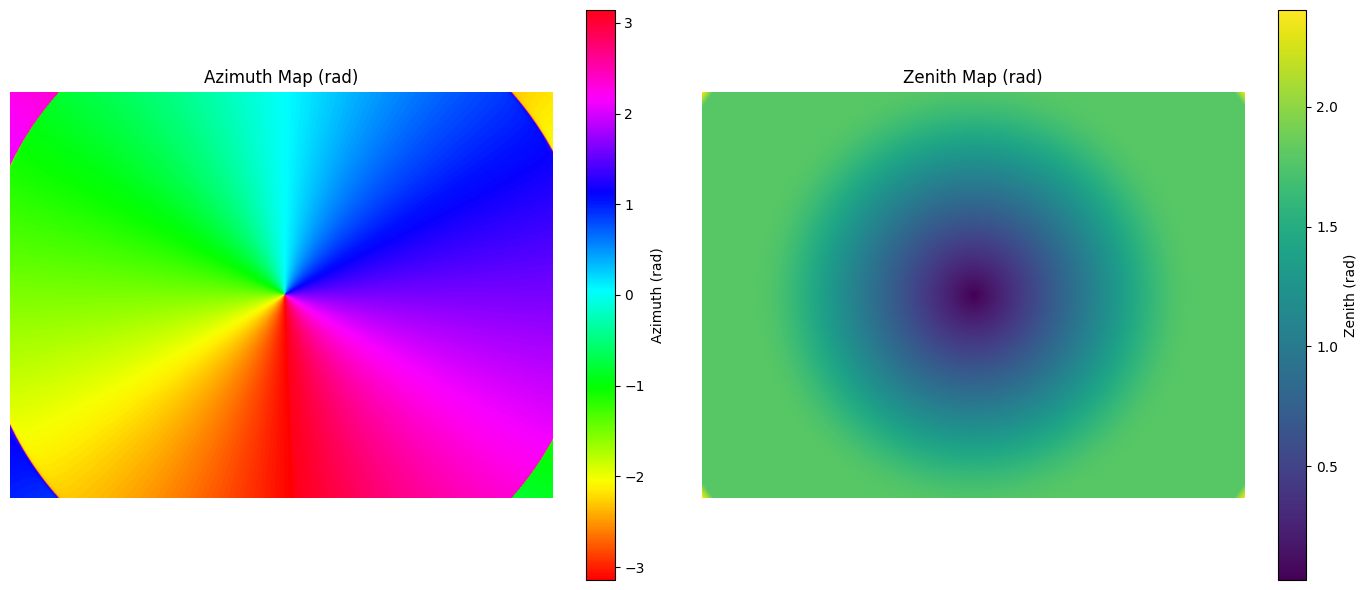

In [15]:
# Load the SIRTA calibration map
calib_path = "/data/common/STEREOSTUDYIPSL/Codebase/config/IPSL/azimuth_zenith_visible_calibration.npz"

if not os.path.exists(calib_path):
    print(f"❌ Calibration file not found: {calib_path}")
else:
    calib_data = np.load(calib_path)
    azimuth_map = calib_data['azimuth']  # in radians
    zenith_map = calib_data['zenith']    # in radians
    
    # Radially enforce that zenith never decreases after reaching π/2
    # This ensures corners stay at π/2 if they're beyond the horizon circle
    h, w = zenith_map.shape
    center_y, center_x = h // 2, w // 2
    
    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:h, :w]
    
    # Calculate radial distance from center
    radial_dist = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    
    # For each unique radius, find the maximum zenith value
    # Then propagate that maximum to all pixels at greater radii
    zenith_map_corrected = zenith_map.copy()
    
    # Get unique radii and sort them
    unique_radii = np.unique(radial_dist.ravel())
    unique_radii = np.sort(unique_radii)
    
    # Track the maximum zenith seen so far (monotonically increasing radially)
    max_zenith_so_far = 0
    
    for radius in unique_radii:
        # Get all pixels at this radius
        mask = np.abs(radial_dist - radius) < 0.5
        
        # Get the maximum zenith at this radius
        zenith_at_radius = zenith_map[mask]
        if len(zenith_at_radius) > 0:
            current_max = np.max(zenith_at_radius)
            
            # Update max_zenith_so_far to be monotonically increasing
            max_zenith_so_far = max(max_zenith_so_far, current_max)
            
            # Set all pixels at this radius to at least max_zenith_so_far
            zenith_map_corrected[mask] = np.maximum(zenith_map_corrected[mask], max_zenith_so_far)
    
    zenith_map = zenith_map_corrected
    
    print(f"✓ Loaded SIRTA calibration map")
    print(f"  Shape: {azimuth_map.shape}")
    print(f"  Azimuth range: [{azimuth_map.min():.1f}, {azimuth_map.max():.1f}] rad")
    print(f"  Zenith range: [{zenith_map.min():.1f}, {zenith_map.max():.1f}] rad")
    
    # Visualize the calibration maps
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    im1 = axes[0].imshow(azimuth_map, cmap='hsv')
    axes[0].set_title('Azimuth Map (rad)', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], label='Azimuth (rad)')
    
    im2 = axes[1].imshow(zenith_map, cmap='viridis')
    axes[1].set_title('Zenith Map (rad)', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], label='Zenith (rad)')
    
    plt.tight_layout()
    plt.show()

## 15. Test Projection with SIRTA Calibration

Testing projection on: 20250406110000_01.jpg
Projecting image...
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
✓ Projection complete
  Input shape: (768, 1024, 3)
  Output shape: (1024, 1024, 3)


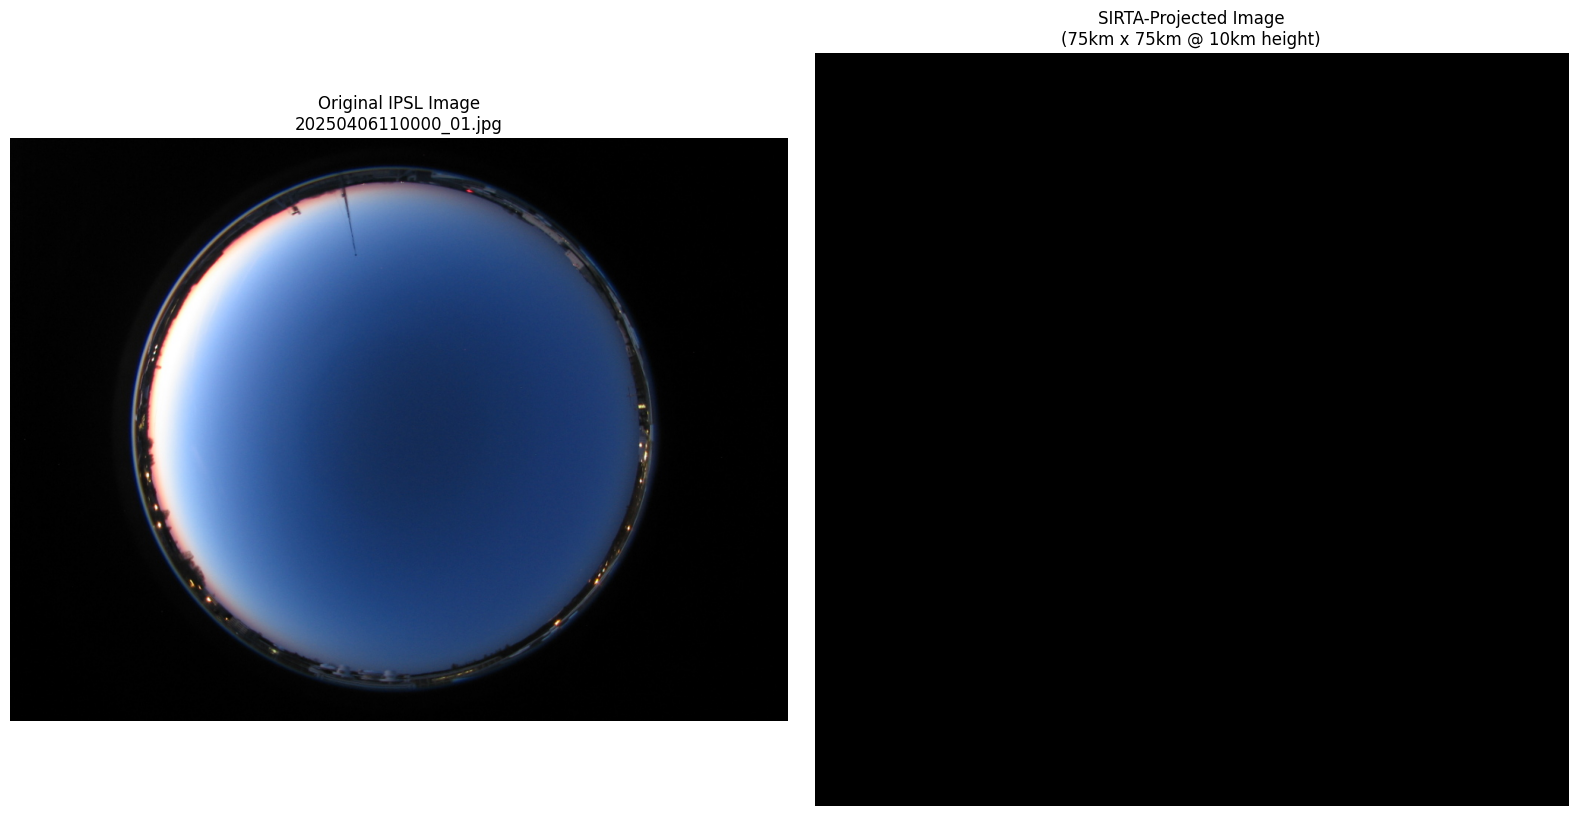

In [16]:
# Import the projection function from batch_reproject_2.py
sys.path.insert(0, str(workspace_dir / "Codebase" / "src" / "processing"))
from batch_reproject_dataset import project_image_with_interpolation
from batch_reproject_2 import project_image_sirta

# Test projection on a sample IPSL image
if len(matched_pairs) > 0:
    test_pair = matched_pairs[0]
    
    print(f"Testing projection on: {test_pair['ipsl_filename']}")
    
    # Load the raw IPSL image
    ipsl_path_test = "/data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/RAW/20250406/20250406044600_01.jpg"
    ipsl_raw = np.array(Image.open(ipsl_path_test).convert('RGB'))
    
    # Convert calibration to radians
    azimuth_rad = np.radians(azimuth_map)
    zenith_rad = np.radians(zenith_map)
    
    # Project the image
    print("Projecting image...")
    ipsl_projected = project_image_with_interpolation(
        ipsl_raw,
        azimuth_rad,
        zenith_rad,
        square_size_km=75,
        resolution=1024,  # Output resolution
        cloud_height_km=10.0
        )
    
    print(ipsl_projected)
    print(f"✓ Projection complete")
    print(f"  Input shape: {ipsl_raw.shape}")
    print(f"  Output shape: {ipsl_projected.shape}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(ipsl_raw)
    axes[0].set_title(f'Original IPSL Image\n{test_pair["ipsl_filename"]}', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(ipsl_projected)
    axes[1].set_title('SIRTA-Projected Image\n(75km x 75km @ 10km height)', fontsize=12)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    ipsl_raw = np.array(Image.open(test_pair['ipsl_path']).convert('RGB'))
else:
    print("No matched pairs available for testing")


## 16. Compare All Three Projections Side-by-Side

Comparing projections for: 2025-04-06 11:08:00
Initialized interpolators:
  Valid pixels: 786432 / 786432
  Image size: (768, 1024)


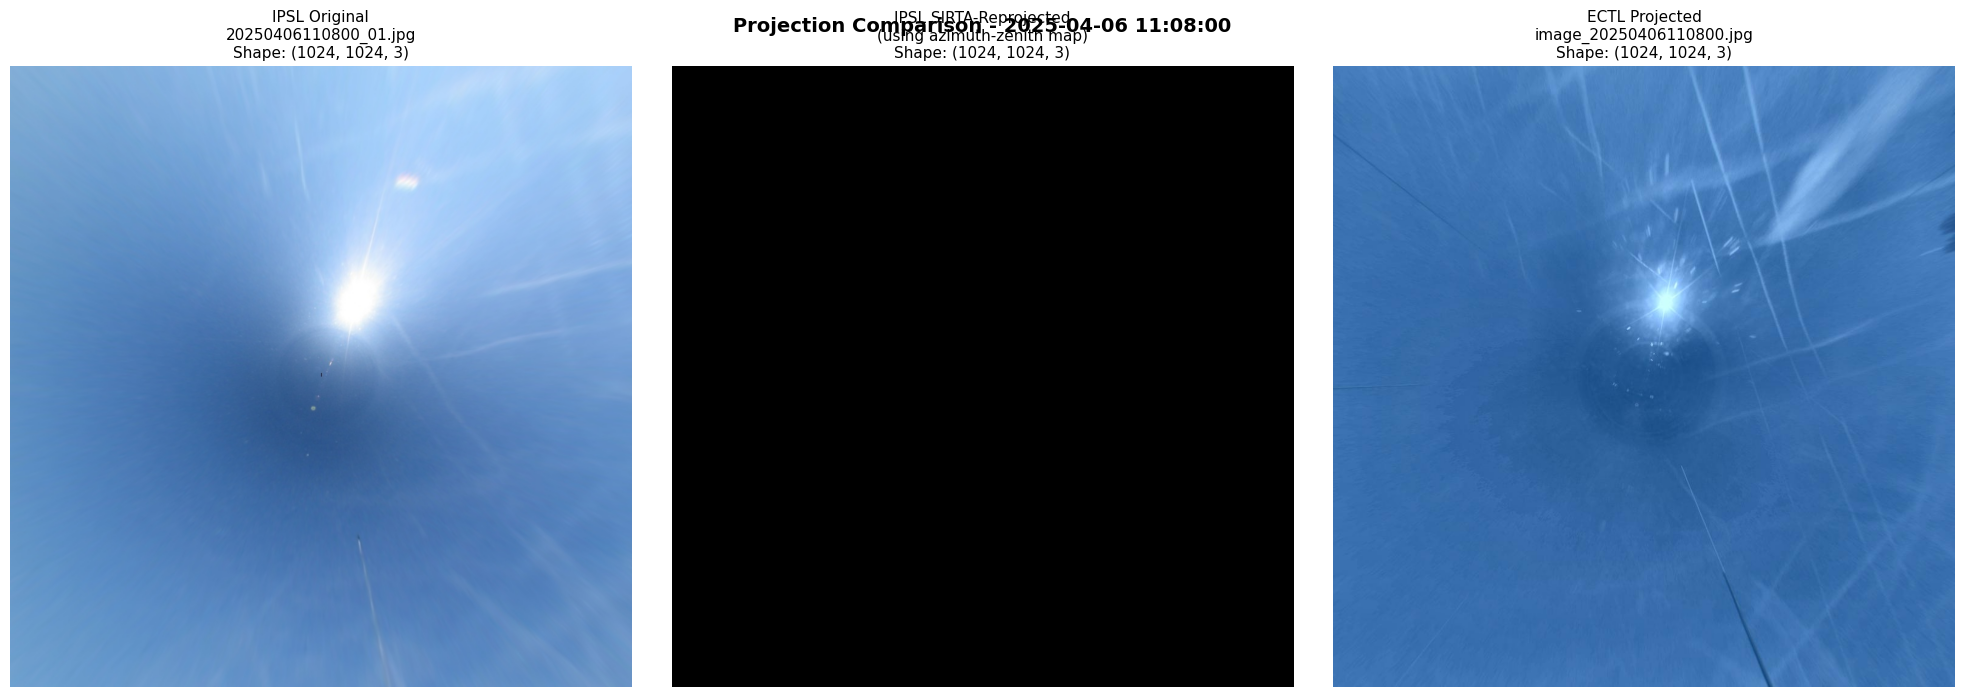

✓ Comparison complete


In [17]:
# Compare: IPSL projected, ECTL projected, and SIRTA-reprojected IPSL
if len(matched_pairs) > 0:
    test_pair = matched_pairs[4]
    
    print(f"Comparing projections for: {test_pair['timestamp']}")
    
    # Load all three images
    ipsl_original = np.array(Image.open(test_pair['ipsl_path']).convert('RGB'))
    ectl_projected = np.array(Image.open(test_pair['ectl_path']).convert('RGB'))
    ectl_projected = np.flipud(ectl_projected)  # Flip ECTL
    
    # Reproject IPSL using SIRTA calibration
    azimuth_rad = np.radians(azimuth_map)
    zenith_rad = np.radians(zenith_map)
    ipsl_reprojected = project_image_sirta(
        ipsl_original,
        azimuth_rad,
        zenith_rad,
        square_size_km=75,
        resolution=1024,
        cloud_height_km=10.0,
        max_zenith_deg=80
    )
    
    # Create side-by-side visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    axes[0].imshow(ipsl_original)
    axes[0].set_title(f'IPSL Original\n{test_pair["ipsl_filename"]}\nShape: {ipsl_original.shape}', fontsize=11)
    axes[0].axis('off')
    
    axes[1].imshow(ipsl_reprojected)
    axes[1].set_title('IPSL SIRTA-Reprojected\n(using azimuth-zenith map)\nShape: {}'.format(ipsl_reprojected.shape), fontsize=11)
    axes[1].axis('off')
    
    axes[2].imshow(ectl_projected)
    axes[2].set_title(f'ECTL Projected\n{test_pair["ectl_filename"]}\nShape: {ectl_projected.shape}', fontsize=11)
    axes[2].axis('off')
    
    plt.suptitle(f'Projection Comparison - {test_pair["timestamp"]}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison complete")
else:
    print("No matched pairs available")

## 17. Load Flight Trajectory Data

In [18]:
# Load flight trajectory data for the matched timestamps
import pandas as pd

# Path to flight data (adjust as needed)
flight_data_dir = workspace_dir / "FlightData"

# For now, let's create a sample flight trajectory
# In reality, you'd load from your actual flight data files
def load_flight_data_for_timestamp(timestamp):
    """
    Load flight data from parquet file.
    Returns DataFrame with columns: latitude, longitude, flight_id, timestamp
    
    Note: Parquet file contains aggregated data (mean positions), not individual waypoints.
    """
    try:
        # Load the parquet file
        parquet_file = flight_data_dir / "2025-04-06.parquet"
        
        if not parquet_file.exists():
            print(f"⚠ Flight data file not found: {parquet_file}")
            return pd.DataFrame(columns=['latitude', 'longitude', 'altitude', 'flight_id', 'timestamp'])
        
        flights_summary = pd.read_parquet(parquet_file)
        
        # Transform aggregated data into compatible format
        flights_data = pd.DataFrame({
            'flight_id': flights_summary['callsign'],
            'latitude': flights_summary['lat_mean'],
            'longitude': flights_summary['lon_mean'],
            'altitude': flights_summary['alt_mean'],
            'timestamp': timestamp  # Use the provided timestamp for all flights
        })
        
        # Filter out invalid data
        flights_data = flights_data.dropna(subset=['latitude', 'longitude', 'altitude'])
        
        return flights_data
        
    except Exception as e:
        print(f"✗ Error loading flight data: {e}")
        return pd.DataFrame(columns=['latitude', 'longitude', 'altitude', 'flight_id', 'timestamp'])


## 18. Project Flight Coordinates to Camera Pixels

In [19]:
def calculate_azimuth_zenith_from_latlon(lat, lon, altitude_m, 
                                         camera_lat, camera_lon, camera_height_m):
    """
    Calculate azimuth and zenith angles from lat/lon/altitude to camera position.
    
    Args:
        lat, lon: Target position (degrees)
        altitude_m: Target altitude (meters)
        camera_lat, camera_lon: Camera position (degrees)
        camera_height_m: Camera height above ground (meters)
    
    Returns:
        azimuth (radians), zenith (radians)
    """
    from geographiclib.geodesic import Geodesic
    
    # WGS84 ellipsoid
    wgs84 = Geodesic.WGS84
    
    # Compute geodesic inverse between camera and target
    inverse = wgs84.Inverse(camera_lat, camera_lon, lat, lon)
    
    # Azimuth from camera to target (degrees)
    azimuth_deg = inverse['azi1']
    
    # Distance on surface (meters)
    distance_surface = inverse['s12']
    
    # Altitude difference
    delta_altitude = altitude_m - camera_height_m
    
    # Straight-line distance
    straight_distance = np.sqrt(distance_surface**2 + delta_altitude**2)
    
    # Elevation angle (degrees)
    elevation_deg = np.degrees(np.arcsin(delta_altitude / straight_distance))
    
    # Zenith angle = 90 - elevation
    zenith_deg = 90 - elevation_deg
    
    # Convert to radians
    azimuth_rad = np.radians(azimuth_deg)
    zenith_rad = np.radians(zenith_deg)
    
    return azimuth_rad, zenith_rad


def project_flight_to_image_coordinates(flights_df, azimuth_map, zenith_map,
                                        camera_lat=48.713, camera_lon=2.208, camera_height=162):
    """
    Project flight coordinates to image pixel coordinates using azimuth-zenith map.
    
    Args:
        flights_df: DataFrame with columns [latitude, longitude, altitude_m, ...]
        azimuth_map: 2D array of azimuth values (radians) from camera calibration
        zenith_map: 2D array of zenith values (radians) from camera calibration
        camera_lat, camera_lon: Camera position (SIRTA location)
        camera_height: Camera height in meters
    
    Returns:
        DataFrame with added columns [pixel_x, pixel_y, visible]
    """
    from scipy.interpolate import LinearNDInterpolator
    
    # Create a copy of the dataframe
    result_df = flights_df.copy()
    
    # Calculate azimuth and zenith for each flight point
    azimuths = []
    zeniths = []
    
    for idx, row in flights_df.iterrows():
        az, zen = calculate_azimuth_zenith_from_latlon(
            row['latitude'], row['longitude'], row['altitude_m'],
            camera_lat, camera_lon, camera_height
        )
        azimuths.append(az)
        zeniths.append(zen)
    
    result_df['azimuth_rad'] = azimuths
    result_df['zenith_rad'] = zeniths
    
    # Create interpolator from azimuth-zenith to pixel coordinates
    # Flatten the calibration maps
    h, w = azimuth_map.shape
    valid_mask = ~(np.isnan(azimuth_map) | np.isnan(zenith_map))
    
    # Get valid azimuth-zenith pairs
    valid_az = azimuth_map[valid_mask].flatten()
    valid_zen = zenith_map[valid_mask].flatten()
    
    # Get corresponding pixel coordinates
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    valid_y = y_coords[valid_mask].flatten()
    valid_x = x_coords[valid_mask].flatten()
    
    # Create interpolator
    points = np.column_stack([valid_az, valid_zen])
    values = np.column_stack([valid_x, valid_y])
    interpolator = LinearNDInterpolator(points, values)
    
    # Interpolate pixel coordinates for flights
    flight_points = np.column_stack([result_df['azimuth_rad'], result_df['zenith_rad']])
    pixel_coords = interpolator(flight_points)
    
    result_df['pixel_x'] = pixel_coords[:, 0]
    result_df['pixel_y'] = pixel_coords[:, 1]
    
    # Mark as visible if within image bounds and not NaN
    result_df['visible'] = (
        ~np.isnan(result_df['pixel_x']) & 
        ~np.isnan(result_df['pixel_y']) &
        (result_df['pixel_x'] >= 0) & 
        (result_df['pixel_x'] < w) &
        (result_df['pixel_y'] >= 0) & 
        (result_df['pixel_y'] < h)
    )
    
    return result_df

print("✓ Flight projection functions defined")

✓ Flight projection functions defined


## 19. Visualize Flights on Camera Images

In [20]:
def visualize_flights_on_image(image, flights_df, title="Flights on Camera Image"):
    """
    Visualize flight trajectories overlaid on camera image.
    
    Args:
        image: Camera image (numpy array)
        flights_df: DataFrame with columns [pixel_x, pixel_y, visible, flight_id, ...]
        title: Plot title
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Show image
    ax.imshow(image)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    # Filter visible flights
    visible_flights = flights_df[flights_df['visible']].copy()
    
    if len(visible_flights) > 0:
        # Plot each flight trajectory
        if 'flight_id' in visible_flights.columns:
            for flight_id in visible_flights['flight_id'].unique():
                flight_data = visible_flights[visible_flights['flight_id'] == flight_id]
                
                # Plot trajectory line
                ax.plot(flight_data['pixel_x'], flight_data['pixel_y'], 
                       'o-', linewidth=2, markersize=4, alpha=0.7, label=f'Flight {flight_id}')
                
                # Mark start and end
                if len(flight_data) > 0:
                    start = flight_data.iloc[0]
                    end = flight_data.iloc[-1]
                    ax.plot(start['pixel_x'], start['pixel_y'], 'go', markersize=8, label='Start')
                    ax.plot(end['pixel_x'], end['pixel_y'], 'ro', markersize=8, label='End')
        else:
            # Plot all points
            ax.scatter(visible_flights['pixel_x'], visible_flights['pixel_y'], 
                      c='red', s=50, alpha=0.7, label='Flight positions')
        
        ax.legend(loc='upper right')
        print(f"✓ Plotted {len(visible_flights)} visible flight points")
    else:
        print("⚠ No visible flights in this image")
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

✓ Visualization function defined


## 20. Test Flight Projection on Sample Image [Not real data]

Testing flight projection on: 2025-04-06 11:00:00

Sample flight data:
   latitude  longitude  altitude_m flight_id           timestamp
0     48.75       2.20       10000     AF123 2025-04-06 11:00:00
1     48.76       2.21       10000     AF123 2025-04-06 11:00:00
2     48.77       2.22       10000     AF123 2025-04-06 11:00:00
3     48.78       2.23       10000     AF123 2025-04-06 11:00:00

Projecting flights to image coordinates...

Projected flight coordinates:
   latitude  longitude  altitude_m     pixel_x     pixel_y  visible
0     48.75       2.20       10000  503.950736  302.215647     True
1     48.76       2.21       10000  517.703214  282.159415     True
2     48.77       2.22       10000  530.654150  264.049200     True
3     48.78       2.23       10000  542.583410  248.155517     True
✓ Plotted 4 visible flight points


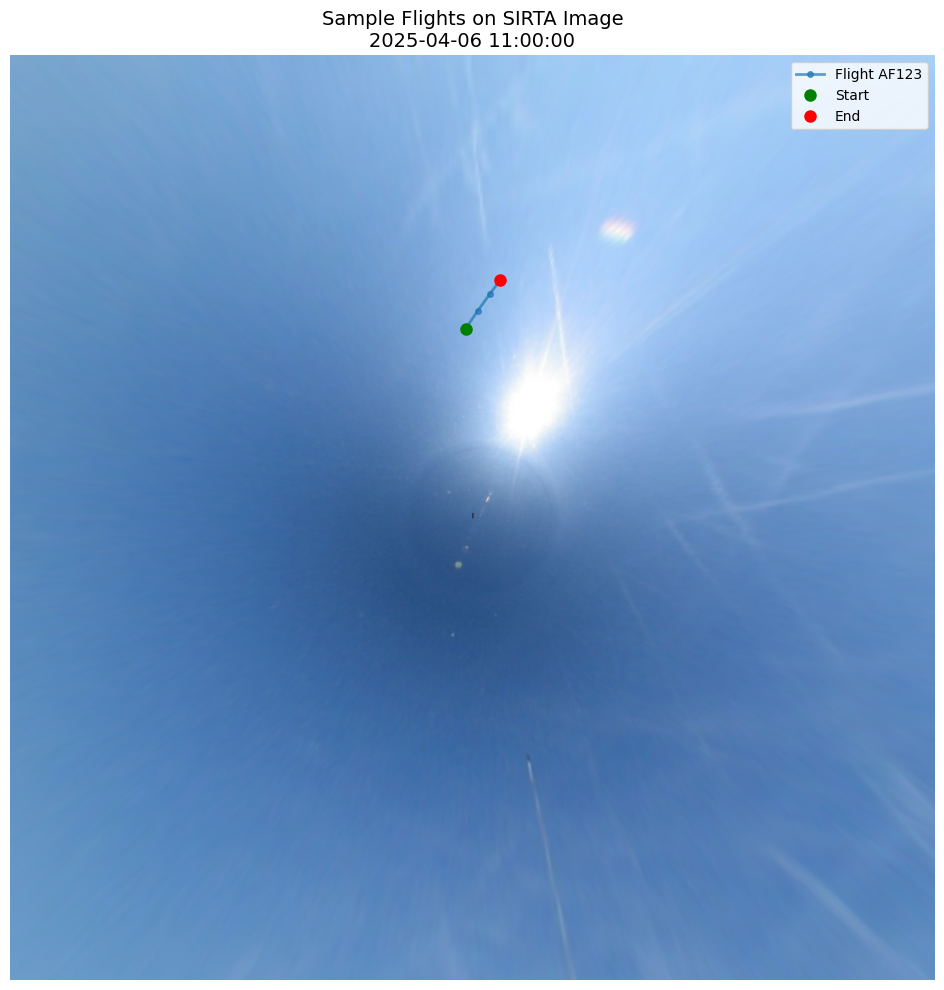

In [21]:
# Test with sample data
if len(matched_pairs) > 0:
    test_pair = matched_pairs[0]
    
    print(f"Testing flight projection on: {test_pair['timestamp']}")
    
    # Load IPSL image (original, not projected)
    ipsl_raw_dir = datasets_dir / DATASET1_NAME / "PROJECTED" 
    # Find the raw image matching this timestamp
    timestamp_str = test_pair['timestamp'].strftime('%Y%m%d%H%M%S')
    raw_image_path = list(ipsl_raw_dir.glob(f'{timestamp_str}_*.jpg'))
    
    if len(raw_image_path) > 0:
        ipsl_image = np.array(Image.open(raw_image_path[0]).convert('RGB'))
        
        # Create sample flight data (replace with your actual data)
        # Example: a flight passing through the field of view
        sample_flights = pd.DataFrame({
            'latitude': [48.75, 48.76, 48.77, 48.78],  # North of SIRTA
            'longitude': [2.20, 2.21, 2.22, 2.23],
            'altitude_m': [10000, 10000, 10000, 10000],  # 10km altitude
            'flight_id': ['AF123', 'AF123', 'AF123', 'AF123'],
            'timestamp': [test_pair['timestamp']] * 4
        })
        
        print("\nSample flight data:")
        print(sample_flights)
        
        # SIRTA camera location
        SIRTA_LAT = 48.7132
        SIRTA_LON = 2.207
        SIRTA_HEIGHT = 177.5  # meters above sea level
        
        # Convert azimuth/zenith maps to radians if needed
        azimuth_rad = np.radians(azimuth_map) if azimuth_map.max() > 10 else azimuth_map
        zenith_rad = np.radians(zenith_map) if zenith_map.max() > 10 else zenith_map
        
        # Project flights to image coordinates
        print("\nProjecting flights to image coordinates...")
        projected_flights = project_flight_to_image_coordinates(
            sample_flights,
            azimuth_rad,
            zenith_rad,
            camera_lat=SIRTA_LAT,
            camera_lon=SIRTA_LON,
            camera_height=SIRTA_HEIGHT
        )
        
        print("\nProjected flight coordinates:")
        print(projected_flights[['latitude', 'longitude', 'altitude_m', 'pixel_x', 'pixel_y', 'visible']])
        
        # Visualize
        visualize_flights_on_image(
            ipsl_image,
            projected_flights,
            title=f"Sample Flights on SIRTA Image\n{test_pair['timestamp']}"
        )
    else:
        print(f"Raw image not found in {ipsl_raw_dir}")
    
else:
    print("No matched pairs available for testing")

## 21. Instructions for Using Real Flight Data

To use this with your actual flight data:

1. **Load your flight trajectory data** in cell 18:
   ```python
   def load_flight_data_for_timestamp(timestamp):
       # Load from your CSV/database/API
       flights_df = pd.read_csv(f'path/to/flights_{timestamp}.csv')
       # Ensure columns: latitude, longitude, altitude_m, flight_id
       return flights_df

In [22]:
# # Add skycam library to path
# betatesting_path = workspace_dir / "Betatesting" / "skycam" / "src"
# if str(betatesting_path) not in sys.path:
#     sys.path.insert(0, str(betatesting_path))

# # Import skycam components
# from skycam.adapters.calibration import JP2CalibrationLoader
# from skycam.domain.aircraft_projection import AircraftProjector, AircraftProjectionSettings

# print("✓ skycam library imported successfully")

In [23]:
# # Load ECTL calibration data
# ectl_calib_dir = workspace_dir / "Codebase" / "config" / "ECTL"

# print(f"Loading ECTL calibration from: {ectl_calib_dir}")
# print(f"  Directory exists: {ectl_calib_dir.exists()}")

# if ectl_calib_dir.exists():
#     # Use JP2CalibrationLoader from skycam
#     loader = JP2CalibrationLoader(ectl_calib_dir)
#     ectl_calibration = loader.load("visible")
    
#     print(f"\n✓ Loaded ECTL calibration")
#     print(f"  Azimuth shape: {ectl_calibration.azimuth_array.shape}")
#     print(f"  Zenith shape: {ectl_calibration.zenith_array.shape}")
#     print(f"  Azimuth range: [{np.nanmin(ectl_calibration.azimuth_array):.1f}, {np.nanmax(ectl_calibration.azimuth_array):.1f}] rad")
#     print(f"  Zenith range: [{np.nanmin(ectl_calibration.zenith_array):.1f}, {np.nanmax(ectl_calibration.zenith_array):.1f}] rad")
    
#     # Visualize ECTL calibration
#     fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
#     im1 = axes[0].imshow(np.degrees(ectl_calibration.azimuth_array), cmap='hsv')
#     axes[0].set_title('ECTL Azimuth Map (degrees)', fontsize=12)
#     axes[0].axis('off')
#     plt.colorbar(im1, ax=axes[0], label='Azimuth (deg)')
    
#     im2 = axes[1].imshow(np.degrees(ectl_calibration.zenith_array), cmap='viridis')
#     axes[1].set_title('ECTL Zenith Map (degrees)', fontsize=12)
#     axes[1].axis('off')
#     plt.colorbar(im2, ax=axes[1], label='Zenith (deg)')
    
#     plt.tight_layout()
#     plt.show()
# else:
#     print(f"❌ ECTL calibration directory not found: {ectl_calib_dir}")

In [24]:
# ECTL camera location (Bretigny-sur-Orge, France)
ECTL_LAT = 48.600518087374105 # degrees
ECTL_LON = 2.3467954996250784   # degrees  
ECTL_ALT = 90    # meters above sea level

# Create projection settings matching our grid
projection_settings = AircraftProjectionSettings(
    cloud_height=10000.00,  # 10km altitude plane
    square_size=75000.0,   # 75km x 75km
    resolution=1024        # 1024x1024 pixels
)

# Initialize the aircraft projector
aircraft_projector = AircraftProjector(
    camera_lat=ECTL_LAT,
    camera_lon=ECTL_LON,
    camera_alt=ECTL_ALT,
    settings=projection_settings
)

print("✓ AircraftProjector initialized for ECTL camera")
print(f"  Location: {ECTL_LAT}°N, {ECTL_LON}°E @ {ECTL_ALT}m")
print(f"  Projection plane: {projection_settings.cloud_height/1000:.1f}km altitude")
print(f"  Coverage: {projection_settings.square_size/1000:.0f}km × {projection_settings.square_size/1000:.0f}km")
print(f"  Resolution: {projection_settings.resolution}×{projection_settings.resolution} pixels")
print(f"  Ground resolution: {projection_settings.square_size/projection_settings.resolution:.1f} m/pixel")

NameError: name 'AircraftProjectionSettings' is not defined

In [ ]:
# Load flight data from Flights folder
flights_dir = workspace_dir / "Flights"
flight_csv = flights_dir / "2025-04-06_final.csv"


print(f"Loading flight data from: {flight_csv}")
print(f"  File exists: {flight_csv.exists()}")

if flight_csv.exists():
    flights_raw = pd.read_csv(flight_csv)
    # rename time to timestamp
    flights_raw = flights_raw.rename(columns={'time': 'timestamp'})
    # change it in original file
    flights_raw.to_csv(flight_csv, index=False)
    print(f"\n✓ Loaded {len(flights_raw)} flight records")
    print(f"  Columns: {flights_raw.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(flights_raw.head())
    
    # Standardize column names - use _mean columns for coordinates
    # col_mapping = {}
    # for col in flights_raw.columns:
    #     col_lower = col.lower()
    #     if 'lat_mean' in col_lower:
    #         col_mapping[col] = 'latitude'
    #     elif 'lon_mean' in col_lower:
    #         col_mapping[col] = 'longitude'
    #     elif 'alt_mean' in col_lower:
    #         col_mapping[col] = 'altitude_m'
    #     elif 'first_seen' in col_lower:
    #         col_mapping[col] = 'timestamp'
    #     elif col == 'flight_id' or col == 'callsign':
    #         # Keep existing flight_id or use callsign
    #         if 'flight_id' not in col_mapping:
    #             col_mapping[col] = 'flight_id'
    
    # if col_mapping:
    #     flights_df = flights_raw.rename(columns=col_mapping)
    #     print(f"\n✓ Standardized column names: {col_mapping}")
    # else:
    #     flights_df = flights_raw.copy()
    # Convert altitude to meters from flight level
    if 'level' in flights_raw.columns:
        print("\n  Converting altitude from flight level to meters...")
        flights_raw['altitude_m'] = flights_raw['level'] * 100 * 0.3048
        flights_raw['altitude'] = flights_raw['level'] * 100 
        print(f"  Altitude range: {flights_raw['altitude_m'].min():.0f} - {flights_raw['altitude_m'].max():.0f} m")
    # Convert altitude from feet to meters if needed
    if 'altitude_m' in flights_raw.columns:
        median_alt = flights_raw['altitude_m'].median()
        if median_alt > 20000:
            print("\n  Converting altitude from feet to meters...")
            flights_raw['altitude_m'] = flights_raw['altitude'] * 0.3048
            print(f"  Altitude range: {flights_raw['altitude_m'].min():.0f} - {flights_raw['altitude_m'].max():.0f} m")
    
    else:
        #add column
        flights_raw['altitude_m'] = flights_raw['altitude'] * 0.3048
    
    # Parse timestamps if available
    if 'timestamp' in flights_raw.columns:
        flights_raw['timestamp'] = pd.to_datetime(flights_raw['timestamp'], errors='coerce')
        print(f"\n  Time range: {flights_raw['timestamp'].min()} to {flights_raw['timestamp'].max()}")
    
    print(f"\n✓ Flight data ready")
    print(f"  Total records: {len(flights_raw)}")
    if 'flight_id' in flights_raw.columns:
        print(f"  Unique flights: {flights_raw['flight_id'].nunique()}")
    
else:
    print(f"❌ Flight data file not found")
    # Create sample data for demonstration
    flights_df = pd.DataFrame({
        'latitude': [48.75, 48.76, 48.77, 48.78],
        'longitude': [2.20, 2.21, 2.22, 2.23],
        'altitude_m': [10000, 10000, 10000, 10000],
        'flight_id': ['SAMPLE1', 'SAMPLE1', 'SAMPLE1', 'SAMPLE1']
    })
    print("  Using sample data for demonstration")

Loading flight data from: /data/common/STEREOSTUDYIPSL/Flights/2025-04-06_final.csv
  File exists: True

✓ Loaded 70211 flight records
  Columns: ['flight_id', 'timestamp', 'icao24', 'registration', 'typecode', 'callsign', 'latitude', 'longitude', 'altitude', 'geoaltitude', 'groundspeed', 'vertical_rate', 'azimuth', 'zenith', 'distance_from_center_km']

First few rows:
     flight_id                  timestamp  icao24 registration typecode  \
0  RAM845X_005  2025-04-06 05:46:25+00:00  020113       CN-RGR     E190   
1  RAM845X_005  2025-04-06 05:46:30+00:00  020113       CN-RGR     E190   
2  RAM845X_005  2025-04-06 05:46:35+00:00  020113       CN-RGR     E190   
3  RAM845X_005  2025-04-06 05:46:40+00:00  020113       CN-RGR     E190   
4  RAM845X_005  2025-04-06 05:46:45+00:00  020113       CN-RGR     E190   

  callsign   latitude  longitude  altitude  geoaltitude  groundspeed  \
0  RAM845X  49.088730   2.088920   31000.0      31675.0        505.0   
1  RAM845X  49.082657   2.073810 

In [ ]:
# Filter flights for a specific time window matching our images
flights_df = flights_raw.copy()
print(len(matched_pairs))
if len(matched_pairs) > 0 and 'timestamp' in flights_df.columns:
    test_pair = matched_pairs[0]
    target_time = test_pair['timestamp']
    print(target_time)
    
    # Make target_time timezone-aware (UTC) to match flight data
    import pytz
    if target_time.tzinfo is None:
        target_time = pytz.UTC.localize(target_time)
    
    print(f"Filtering flights for timestamp: {target_time}")
    
    # Filter flights within ±5 minutes of image timestamp
    time_window = datetime.timedelta(minutes=5)
    start_time = target_time - time_window
    end_time = target_time 
    
    flights_filtered = flights_df[
        (flights_df['timestamp'] >= start_time) & 
        (flights_df['timestamp'] <= end_time)
    ].copy()
    
    print(flights_filtered)
    print(f"  Found {len(flights_filtered)} flights in time window")
    
    # Filter by altitude (cruising altitude 8-12km, respectively in 26,247 to 39,370 feet)
    if 'altitude' in flights_filtered.columns:
        flights_filtered = flights_filtered[
            (flights_filtered['altitude'] >= 26247) & 
            (flights_filtered['altitude'] <= 39370)
        ]
        print(f"  {len(flights_filtered)} flights at cruising altitude (8-12km)")

    
    max_px = 0 
    max_py = 0
    
    if len(flights_filtered) > 0:
        # Project using skycam AircraftProjector
        print("\n" + "="*80)
        print("PROJECTING FLIGHTS USING SKYCAM")
        print("="*80)
        
        # Extract coordinates as numpy arrays
        lons = flights_filtered['longitude'].values
        lats = flights_filtered['latitude'].values
        alts = flights_filtered['altitude'].values
        
        # Vectorized projection (very fast!)
        px, py = aircraft_projector.lonlat_to_pixels(lons, lats, ft_to_m(alts))
        
        # Add to dataframe
        flights_filtered['pixel_x'] = px
        flights_filtered['pixel_y'] = py
        
        # Mark visible flights (within image bounds)
        resolution = projection_settings.resolution
        flights_filtered['visible'] = (
            ~np.isnan(px) & ~np.isnan(py) &
            (px >= 0) & (px < resolution) &
            (py >= 0) & (py < resolution)
        )
        
        visible_count = flights_filtered['visible'].sum()
        print(f"\n✓ Projection complete")
        print(f"  Total flights: {len(flights_filtered)}")
        print(f"  Visible in camera: {visible_count}")
        print(f"  Visibility rate: {100*visible_count/len(flights_filtered):.1f}%")
        
        if visible_count > 0:
            print(f"\nVisible flights sample:")
            visible_sample = flights_filtered[flights_filtered['visible']][
                ['flight_id', 'latitude', 'longitude', 'altitude', 'pixel_x', 'pixel_y']
            ].head(10)
            print(visible_sample.to_string(index=False))
        
        # Load ECTL projected image
        ectl_image = np.array(Image.open(test_pair['ectl_path']).convert('RGB'))
        ectl_image = np.flipud(ectl_image)  # Flip vertically
        
        print(f"\n✓ Loaded ECTL image: {test_pair['ectl_filename']}")
        print(f"  Shape: {ectl_image.shape}")
        
        # Visualize flights on ECTL image
        print("\nVisualizing flights on ECTL projected image...")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        
        ax.imshow(ectl_image)
        ax.set_title(
            f"Flights Projected onto ECTL Image\n"
            f"{test_pair['ectl_filename']}\n"
            f"{visible_count} visible flights at {target_time}",
            fontsize=14, fontweight='bold'
        )
        ax.axis('off')
        
        # Plot visible flights
        visible_flights = flights_filtered[flights_filtered['visible']]
        
        if len(visible_flights) > 0:
            # Plot individual flight points
            colors = plt.cm.rainbow(np.linspace(0, 1, len(visible_flights['flight_id'].unique())))
            
            for i, flight_id in enumerate(visible_flights['flight_id'].unique()):
                flight_points = visible_flights[visible_flights['flight_id'] == flight_id]
                
                if len(flight_points) > 1:
                    # Plot trajectory line
                    ax.plot(
                        flight_points['pixel_x'], 
                        flight_points['pixel_y'],
                        'o-', 
                        color=colors[i],
                        linewidth=2, 
                        markersize=6, 
                        alpha=0.2,
                        label=f'{flight_id}'
                    )
                else:
                    # Single point
                    ax.plot(
                        flight_points['pixel_x'].values[0],
                        flight_points['pixel_y'].values[0],
                        'o',
                        color=colors[i],
                        markersize=8,
                        alpha=0.2,
                        label=f'{flight_id}'
                    )
            
            # Add legend if not too many flights
            if len(visible_flights['flight_id'].unique()) <= 15:
                ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
            
            print(f"✓ Plotted {len(visible_flights)} visible flight points")
        
        plt.tight_layout()
        plt.show()
        print( flights_filtered['pixel_x'].min(), flights_filtered['pixel_y'].min())
        print( flights_filtered['pixel_x'].max(), flights_filtered['pixel_y'].max())
        
    else:
        print("\n⚠ No flights found in filtered dataset")
    
else:
    print("⚠ No matched image pairs or timestamp column not available")
    print("  Cannot filter flights by time")

60
2025-04-06 13:00:00
Filtering flights for timestamp: 2025-04-06 13:00:00+00:00
          flight_id                 timestamp  icao24 registration typecode  \
45840    DLH05A_800 2025-04-06 12:55:00+00:00  3c6483       D-AIDC     A321   
45841    DLH05A_800 2025-04-06 12:55:05+00:00  3c6483       D-AIDC     A321   
45842    DLH05A_800 2025-04-06 12:55:10+00:00  3c6483       D-AIDC     A321   
45843    DLH05A_800 2025-04-06 12:55:15+00:00  3c6483       D-AIDC     A321   
45844    DLH05A_800 2025-04-06 12:55:20+00:00  3c6483       D-AIDC     A321   
...             ...                       ...     ...          ...      ...   
60773  EZS72PT_2016 2025-04-06 12:58:45+00:00  4b1a1f       HB-JXF     A320   
64634   LGL184_2364 2025-04-06 12:55:00+00:00  4d00c1       LX-LGQ     B737   
64635   LGL184_2364 2025-04-06 12:55:05+00:00  4d00c1       LX-LGQ     B737   
64636   LGL184_2364 2025-04-06 12:55:10+00:00  4d00c1       LX-LGQ     B737   
64637   LGL184_2364 2025-04-06 12:55:15+00:00  4d

NameError: name 'aircraft_projector' is not defined

Filtering flights for timestamp: 2025-04-06 13:00:00+00:00
  Found 523 flights in time window
  497 flights at cruising altitude )

PROJECTING FLIGHTS USING SKYCAM

✓ Projection complete
  Total flights: 497
  Visible in camera: 402
  Visibility rate: 80.9%

Visible flights sample:
 flight_id  latitude  longitude  altitude    pixel_x     pixel_y
DLH05A_800 48.263172   1.966047   34025.0 136.446599 1008.260132
DLH05A_800 48.270714   1.977033   34025.0 147.322181  997.187548
DLH05A_800 48.276672   1.986502   34025.0 156.688914  988.441381
DLH05A_800 48.283218   1.997610   34025.0 167.672439  978.834955
DLH05A_800 48.289627   2.009583   34025.0 179.502552  969.433271
DLH05A_800 48.295200   2.020906   34025.0 190.685941  961.259763
DLH05A_800 48.300693   2.033121   34025.0 202.743878  953.206089
DLH05A_800 48.305649   2.045077   34025.0 214.540753  945.942699
DLH05A_800 48.310237   2.057045   34025.0 226.346069  939.220059
DLH05A_800 48.315216   2.070289   34025.0 239.406089  931.922073

✓

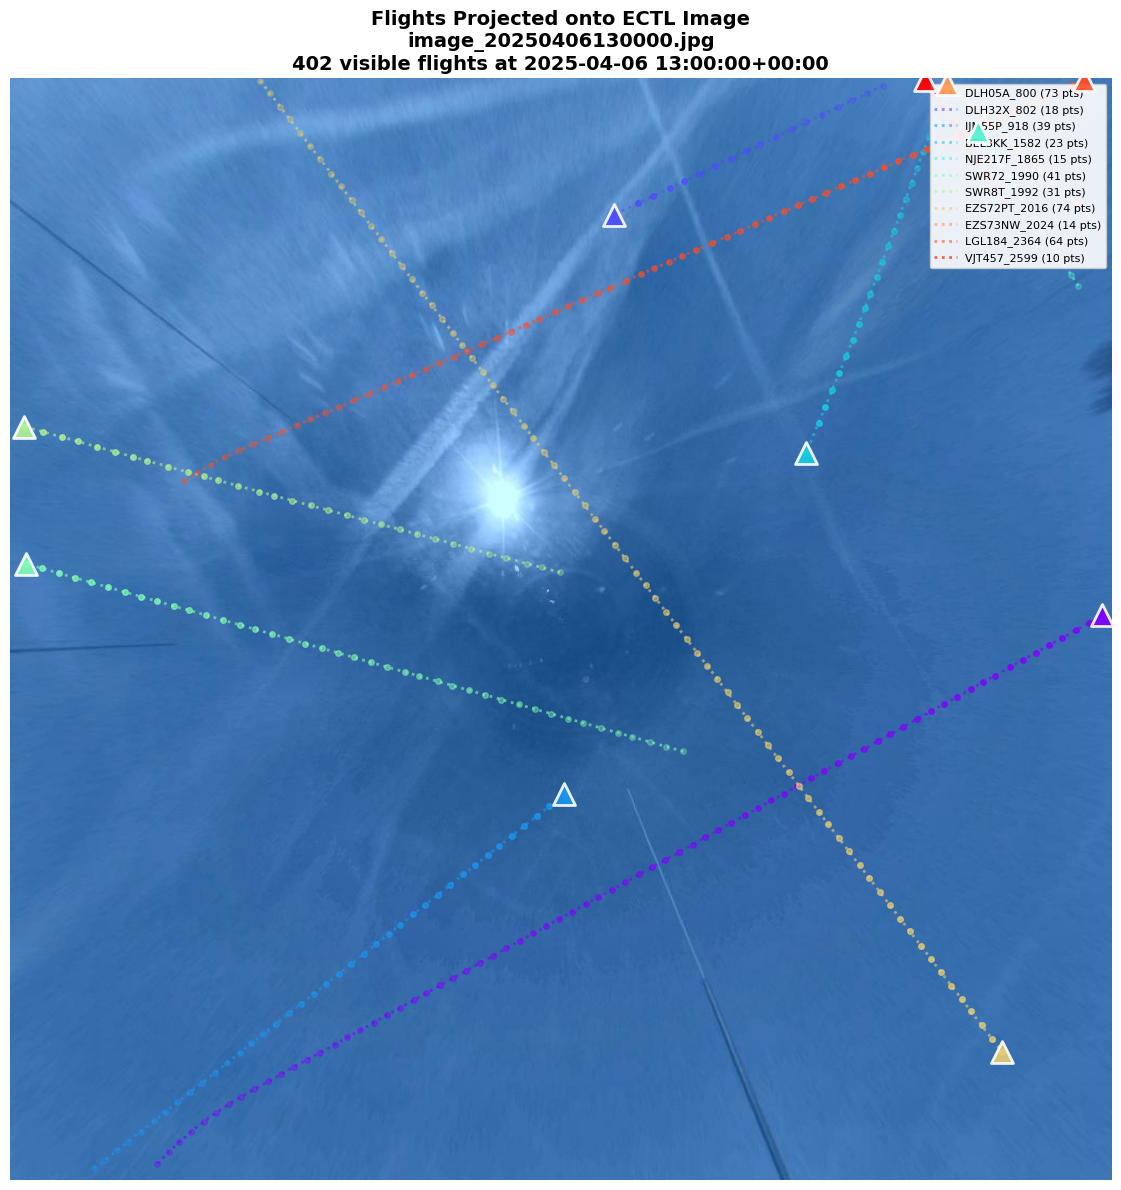

In [ ]:
# Filter flights for a specific time window matching our images
if len(matched_pairs) > 0 and 'timestamp' in flights_df.columns:
    test_pair = matched_pairs[0]
    target_time = test_pair['timestamp']
    
    # Make target_time timezone-aware (UTC) to match flight data
    import pytz
    if target_time.tzinfo is None:
        target_time = pytz.UTC.localize(target_time)
    
    print(f"Filtering flights for timestamp: {target_time}")
    
    # Filter flights within ±5 minutes of image timestamp
    time_window = datetime.timedelta(minutes=10)
    start_time = target_time - time_window
    end_time = target_time 
    
    flights_filtered = flights_df[
        (flights_df['timestamp'] >= start_time) & 
        (flights_df['timestamp'] <= end_time)
    ].copy()
    
    print(f"  Found {len(flights_filtered)} flights in time window")
    
    # Filter by altitude (cruising altitude 8-12km, respectively in 26,247 to 39,370 feet)
    if 'altitude' in flights_filtered.columns:
        flights_filtered = flights_filtered[
            (flights_filtered['altitude'] >= 26247) & 
            (flights_filtered['altitude'] <= 39370)
        ]
        print(f"  {len(flights_filtered)} flights at cruising altitude )")
    
    if len(flights_filtered) > 0:
        # Project using skycam AircraftProjector
        print("\n" + "="*80)
        print("PROJECTING FLIGHTS USING SKYCAM")
        print("="*80)
        
        # Extract coordinates as numpy arrays
        lons = flights_filtered['longitude'].values
        lats = flights_filtered['latitude'].values
        alts = flights_filtered['altitude'].values
        
        # Vectorized projection (very fast!)
        px, py = aircraft_projector.lonlat_to_pixels(lons, lats, ft_to_m(alts))
        
        # Add to dataframe
        flights_filtered['pixel_x'] = px
        flights_filtered['pixel_y'] = py
        
        # Mark visible flights (within image bounds)
        resolution = projection_settings.resolution
        flights_filtered['visible'] = (
            ~np.isnan(px) & ~np.isnan(py) &
            (px >= 0) & (px < resolution) &
            (py >= 0) & (py < resolution)
        )
        
        visible_count = flights_filtered['visible'].sum()
        print(f"\n✓ Projection complete")
        print(f"  Total flights: {len(flights_filtered)}")
        print(f"  Visible in camera: {visible_count}")
        print(f"  Visibility rate: {100*visible_count/len(flights_filtered):.1f}%")
        
        if visible_count > 0:
            print(f"\nVisible flights sample:")
            visible_sample = flights_filtered[flights_filtered['visible']][
                ['flight_id', 'latitude', 'longitude', 'altitude', 'pixel_x', 'pixel_y']
            ].head(10)
            print(visible_sample.to_string(index=False))
        
        # Load ECTL projected image
        ectl_image = np.array(Image.open(test_pair['ectl_path']).convert('RGB'))
        # ectl_image = np.flipud(ectl_image)  # Flip vertically
        
        print(f"\n✓ Loaded ECTL image: {test_pair['ectl_filename']}")
        print(f"  Shape: {ectl_image.shape}")
        
        # Visualize flights on ECTL image
        print("\nVisualizing flights on ECTL projected image...")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        
        # Flip image vertically for correct orientation
        ectl_image = np.flipud(ectl_image)
        ax.imshow(ectl_image)
        ax.set_title(
            f"Flights Projected onto ECTL Image\n"
            f"{test_pair['ectl_filename']}\n"
            f"{visible_count} visible flights at {target_time}",
            fontsize=14, fontweight='bold'
        )
        ax.axis('off')
        
        # Plot visible flights with enhanced visualization
        visible_flights = flights_filtered[flights_filtered['visible']]
        
        if len(visible_flights) > 0:
            # Plot individual flight trajectories
            colors = plt.cm.rainbow(np.linspace(0, 1, len(visible_flights['flight_id'].unique())))
            
            for i, flight_id in enumerate(visible_flights['flight_id'].unique()):
                flight_points = visible_flights[visible_flights['flight_id'] == flight_id].sort_values('timestamp')
                
                if len(flight_points) > 1:
                    # Plot dotted trajectory line for history
                    ax.plot(
                        flight_points['pixel_x'], 
                        flight_points['pixel_y'],
                        ':', 
                        color=colors[i],
                        linewidth=2, 
                        alpha=0.6,
                        label=f'{flight_id} ({len(flight_points)} pts)'
                    )
                    
                    # Plot fading waypoint markers (older = more transparent)
                    num_points = len(flight_points)
                    alphas = np.linspace(0.3, 0.8, num_points)
                    for j, (idx, point) in enumerate(flight_points.iterrows()):
                        ax.plot(
                            point['pixel_x'],
                            point['pixel_y'],
                            'o',
                            color=colors[i],
                            markersize=4,
                            alpha=alphas[j]
                        )
                    
                    # Plot plane icon (triangle) for most recent position
                    last_point = flight_points.iloc[-1]
                    ax.scatter(
                        last_point['pixel_x'],
                        last_point['pixel_y'],
                        marker='^',
                        s=250,
                        color=colors[i],
                        edgecolors='white',
                        linewidths=2,
                        alpha=0.9,
                        zorder=10
                    )
                else:
                    # Single point - show as plane icon
                    ax.scatter(
                        flight_points['pixel_x'].values[0],
                        flight_points['pixel_y'].values[0],
                        marker='^',
                        s=250,
                        color=colors[i],
                        edgecolors='white',
                        linewidths=2,
                        alpha=0.9,
                        label=f'{flight_id}',
                        zorder=10
                    )
            
            # Add legend if not too many flights
            if len(visible_flights['flight_id'].unique()) <= 15:
                ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
            
            num_waypoints = len(visible_flights)
            num_flights = visible_flights['flight_id'].nunique()
            print(f"✓ Plotted {num_flights} flights with {num_waypoints} waypoints total")
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("\n⚠ No flights found in filtered dataset")
        
else:
    print("⚠ No matched image pairs or timestamp column not available")
    print("  Cannot filter flights by time")

In [ ]:
# Test reverse projection: pixel → GPS coordinates
print("Testing reverse projection (pixels → GPS)")
print("="*60)

# Test some pixel coordinates
test_pixels = np.array([
    [512, 512],  # Center of image
    [256, 256],  # Upper left quadrant
    [768, 768],  # Lower right quadrant
])

# Assume 10km altitude
test_altitude = 10000.0

for i, (px, py) in enumerate(test_pixels):
    # Reverse projection
    lon, lat = aircraft_projector.pixels_to_lonlat(
        np.array([px]), 
        np.array([py]), 
        np.array([test_altitude])
    )
    
    print(f"\nTest point {i+1}:")
    print(f"  Pixel: ({px:.0f}, {py:.0f})")
    print(f"  GPS: {lat[0]:.4f}°N, {lon[0]:.4f}°E @ {test_altitude/1000:.1f}km")
    
    # Verify by projecting back
    px_verify, py_verify = aircraft_projector.lonlat_to_pixels(
        lon, lat, np.array([test_altitude])
    )
    
    error_x = abs(px_verify[0] - px)
    error_y = abs(py_verify[0] - py)
    
    print(f"  Verification: ({px_verify[0]:.1f}, {py_verify[0]:.1f})")
    print(f"  Error: {error_x:.3f} px (x), {error_y:.3f} px (y)")
    
print("\n✓ Reverse projection test complete")

Testing reverse projection (pixels → GPS)

Test point 1:
  Pixel: (512, 512)
  GPS: 48.6002°N, 2.3473°E @ 10.0km
  Verification: (512.0, 512.0)
  Error: 0.000 px (x), 0.000 px (y)

Test point 2:
  Pixel: (256, 256)
  GPS: 48.7672°N, 2.0943°E @ 10.0km
  Verification: (256.0, 256.0)
  Error: 0.000 px (x), 0.000 px (y)

Test point 3:
  Pixel: (768, 768)
  GPS: 48.4327°N, 2.5986°E @ 10.0km
  Verification: (768.0, 768.0)
  Error: 0.000 px (x), 0.000 px (y)

✓ Reverse projection test complete


## MiniProjector - Geometric Projection Method

Alternative projection approach using geodesic calculations for accurate Earth-surface geometry.

In [ ]:
import numpy as np
from geographiclib.geodesic import Geodesic
from shapely import transform
from shapely.geometry.base import BaseGeometry
from typing import Tuple, Callable
from numpy.typing import NDArray


# To avoid depending on pycontrails (assuming ft_to_m is needed for consistency with first code)
def ft_to_m(ft: NDArray) -> NDArray:
    """Converts feet to meters."""
    return ft * 0.3048


class MiniProjector:
    """
    Minimal projector converting aircraft positions (lat, lon, alt)
    into extended pixel coordinates using geometric projection,
    and supporting shapely BaseGeometry projection/back-projection.
    """

    # -------------------------
    # Default camera constants
    # -------------------------
    ECTL_LONGITUDE = 2.3467954996250784
    ECTL_LATITUDE = 48.600518087374105
    ECTL_HEIGHT = 90  # In meters, as per the first class

    # -------------------------
    # IPSL camera constants
    # -------------------------
    IPSL_LONGITUDE = 2.207
    IPSL_LATITUDE = 48.7132
    IPSL_HEIGHT = 177.5  # In meters

    def __init__(
        self,
        camera_lat: float = ECTL_LATITUDE,
        camera_lon: float = ECTL_LONGITUDE,
        camera_alt: float = ECTL_HEIGHT,
        cloud_height: float = 10000,
        square_size: float = 75000,
        resolution: int = 1024,
        extension_factor: int = 2,
    ):
        # Camera parameters
        self.camera_lat = camera_lat
        self.camera_lon = camera_lon
        self.camera_alt = camera_alt

        # Projection configuration
        self.cloud_height = cloud_height
        self.square_size = square_size
        self.resolution = resolution
        self.extension_factor = extension_factor

        # Grid geometry
        self.half = square_size / 2
        # self.total_half = extension_factor * self.half / 2 # Unused in minimal logic
        self.step = square_size / (resolution - 1)

        # Earth model
        self.geod = Geodesic.WGS84

    # ------------------------------------------------------------------
    # --- Geographic (Lon/Lat) <-> Spherical (Azimuth/Zenith) Conversions ---
    # ------------------------------------------------------------------

    def calculate_azimuth_zenith(self, lat, lon, alt_ft):
        """Compute azimuth (deg) and zenith (deg) from camera → target."""
        # Note: Input alt is in ft, must convert to meters first!
        alt_m = ft_to_m(np.asarray(alt_ft))

        # Use vectorized Inverse for lon/lat pairs
        inv_results = [
            self.geod.Inverse(self.camera_lat, self.camera_lon, la, lo)
            for la, lo in zip(np.atleast_1d(lat), np.atleast_1d(lon))
        ]

        azi1 = np.array([res["azi1"] for res in inv_results])
        s_ground = np.array([res["s12"] for res in inv_results])

        dz = alt_m - self.camera_alt

        # Straight-line distance between camera and target
        straight = np.sqrt(s_ground**2 + dz**2)

        # Calculate elevation and zenith angles
        elevation = np.degrees(np.arcsin(dz / straight))
        zenith = 90.0 - elevation

        if np.isscalar(lat) and np.isscalar(lon) and np.isscalar(alt_ft):
            return azi1.item(), zenith.item()

        return azi1, zenith

    def azimuth_zenith_to_lonlat(self, azimuth_deg, zenith_deg, alt_ft):
        """Compute target lon/lat from camera azimuth (deg), zenith (deg), and target altitude (ft)."""
        # Note: Input alt is in ft, must convert to meters first!
        alt_m = ft_to_m(np.asarray(alt_ft))

        # Convert zenith to elevation angle in radians
        elevation_rad = np.radians(90.0 - zenith_deg)

        # Altitude difference
        dz = alt_m - self.camera_alt

        # Distance on surface (s_ground)
        # s_ground = dz / tan(elevation)
        distance_on_surface_m = dz / np.tan(elevation_rad)

        # Use vectorized Direct for azimuth/distance pairs
        direct_results = [
            self.geod.Direct(self.camera_lat, self.camera_lon, az, dist)
            for az, dist in zip(
                np.atleast_1d(azimuth_deg), np.atleast_1d(distance_on_surface_m)
            )
        ]

        lon2 = np.array([res["lon2"] for res in direct_results])
        lat2 = np.array([res["lat2"] for res in direct_results])

        if np.isscalar(azimuth_deg) and np.isscalar(zenith_deg) and np.isscalar(alt_ft):
            return lon2.item(), lat2.item()

        return lon2, lat2

    # ------------------------------------------------------------------
    # --- Spherical (Azimuth/Zenith) <-> Planar (X/Y in meters) Conversions ---
    # ------------------------------------------------------------------

    def azimuth_zenith_to_xy(self, azimuth_deg, zenith_deg):
        """Convert azimuth/zenith to projection plane coordinates (x,y) in meters."""
        az = np.radians(azimuth_deg)
        ze = np.radians(zenith_deg)

        r = self.cloud_height * np.tan(ze)

        # x is East/West (cos(az)) and y is North/South (sin(az))
        x = r * np.cos(az)
        y = r * np.sin(az)

        # The pixel mapping is (y_proj, x_proj)
        # self.half - x means x=0 is in the middle of the 'x' axis of the plane
        # y + self.half means y=0 is in the middle of the 'y' axis of the plane
        return y + self.half, self.half - x

    def xy_to_azimuth_zenith(self, x, y):
        """Convert projection plane coordinates (x,y) in meters to azimuth/zenith (deg)."""

        # Reverse the shifting: get back to (0,0) center
        x_centered = self.half - y
        y_centered = x - self.half

        # Calculate radius r from the centered coordinates
        r = np.sqrt(x_centered**2 + y_centered**2)

        # Azimuth in radians
        az_rad = np.arctan2(y_centered, x_centered)
        azimuth_deg = np.degrees(az_rad)

        # Zenith in radians
        ze_rad = np.arctan(r / self.cloud_height)
        zenith_deg = np.degrees(ze_rad)

        return azimuth_deg, zenith_deg

    # ------------------------------------------------------------------
    # --- Planar (X/Y in meters) <-> Pixels (Px/Py) Conversions ---
    # ------------------------------------------------------------------

    def xy_to_pixels(self, x, y):
        """Convert (x,y) in meters to extended pixel coordinates."""
        px = x / self.step
        py = y / self.step
        return px, py

    def pixels_to_xy(self, px, py):
        """Convert extended pixel coordinates to (x,y) in meters."""
        x = px * self.step
        y = py * self.step
        return x, y

    # ------------------------------------------------------------------
    # --- Full Pipeline Conversions ---
    # ------------------------------------------------------------------

    def lonlat_to_pixels(self, lon_deg, lat_deg, alt_ft) -> Tuple[NDArray, NDArray]:
        """Convert longitude/latitude/altitude to pixel coordinates."""
        az_deg, ze_deg = self.calculate_azimuth_zenith(lat_deg, lon_deg, alt_ft)
        x, y = self.azimuth_zenith_to_xy(az_deg, ze_deg)
        px, py = self.xy_to_pixels(x, y)
        return np.asarray(px), np.asarray(py)

    def pixel_to_lonlat(self, px, py, alt_ft) -> Tuple[NDArray, NDArray]:
        """Convert pixel coordinates/altitude to longitude/latitude."""
        x, y = self.pixels_to_xy(px, py)
        az_deg, ze_deg = self.xy_to_azimuth_zenith(x, y)
        lon_deg, lat_deg = self.azimuth_zenith_to_lonlat(az_deg, ze_deg, alt_ft)
        return np.asarray(lon_deg), np.asarray(lat_deg)

    # ------------------------------------------------------------------
    # --- Shapely Projection Methods ---
    # ------------------------------------------------------------------

    def _project_geom(
        self,
        geom: BaseGeometry,
        proj_func: Callable,
    ) -> BaseGeometry:
        """Helper to transform a shapely geometry using a projection function."""
        if geom.is_empty:
            return geom

        # Check for Z coordinate (altitude)
        if not geom.has_z:
            raise ValueError(
                "Coordinates must have shape (N, 3) with longitude, latitude, and altitude (in ft)."
            )

        def wrapper(coords):
            # coords are (lon, lat, alt_ft) or (px, py, alt_ft)
            c1 = coords[:, 0]
            c2 = coords[:, 1]
            alt_ft = np.asarray(coords[:, 2])

            # The projection function handles the conversion (e.g., lonlat -> pixels)
            c1_proj, c2_proj = proj_func(c1, c2, alt_ft)

            # Result coordinates are (proj_coord1, proj_coord2, alt_ft)
            return np.column_stack((c1_proj, c2_proj, alt_ft))

        return transform(geom, wrapper, include_z=True)

    def project(
        self,
        geom: BaseGeometry,
    ) -> BaseGeometry:
        """
        Projects a BaseGeometry from (longitude, latitude, altitude_ft)
        to (pixel_x, pixel_y, altitude_ft).
        """
        # The input coordinates are (lon, lat, alt_ft)
        return self._project_geom(geom, self.lonlat_to_pixels)

    def project_back(
        self,
        geom: BaseGeometry,
    ) -> BaseGeometry:
        """
        Projects a BaseGeometry back from (pixel_x, pixel_y, altitude_ft)
        to (longitude, latitude, altitude_ft).
        """
        # The input coordinates are (px, py, alt_ft)
        return self._project_geom(geom, self.pixel_to_lonlat)


print("✓ MiniProjector class defined")

✓ MiniProjector class defined


In [ ]:
# Project and visualize flights using MiniProjector

# define MiniProjector instance
mini_projector = MiniProjector(
    camera_lat=SIRTA_LAT,
    camera_lon=SIRTA_LON,
    camera_alt=SIRTA_HEIGHT,
    cloud_height=10000.0,  # 10km altitude plane
    square_size=75000.0,   # 75km x 75km
    resolution=1024        # 1024x1024 pixels
)

if len(matched_pairs) > 0 and 'timestamp' in flights_df.columns:
    test_pair = matched_pairs[0]
    target_time = test_pair['timestamp']
    
    # Make target_time timezone-aware (UTC) to match flight data
    import pytz
    if target_time.tzinfo is None:
        target_time = pytz.UTC.localize(target_time)
    
    print(f"Filtering flights for timestamp: {target_time}")
    
    # Filter flights within ±5 minutes of image timestamp
    time_window = datetime.timedelta(minutes=5)
    start_time = target_time - time_window
    end_time = target_time + time_window
    
    flights_filtered_mini = flights_df[
        (flights_df['timestamp'] >= start_time) & 
        (flights_df['timestamp'] <= end_time)
    ].copy()
    
    print(f"  Found {len(flights_filtered_mini)} flights in time window")
    
    # Filter by altitude (cruising altitude 8-12km)
    if 'altitude_m' in flights_filtered_mini.columns:
        flights_filtered_mini = flights_filtered_mini[
            (flights_filtered_mini['altitude_m'] >= 8000) & 
            (flights_filtered_mini['altitude_m'] <= 12000)
        ]
        print(f"  {len(flights_filtered_mini)} flights at cruising altitude (8-12km)")
    
    if len(flights_filtered_mini) > 0:
        # Project using MiniProjector
        print("\n" + "="*80)
        print("PROJECTING FLIGHTS USING MINIPROJECTOR (GEOMETRIC METHOD)")
        print("="*80)
        
        # Extract coordinates as numpy arrays
        lons = flights_filtered_mini['longitude'].values
        lats = flights_filtered_mini['latitude'].values
        alts = flights_filtered_mini['altitude'].values
        
        # CRITICAL: MiniProjector expects altitude in FEET, not meters
        # alts_ft = alts_m / 0.3048
        
        # Vectorized projection using MiniProjector
        px, py = mini_projector.lonlat_to_pixels(lons, lats, alts)
        
        # Add to dataframe
        flights_filtered_mini['pixel_x'] = px
        flights_filtered_mini['pixel_y'] = py
        
        # Mark visible flights (within image bounds)
        resolution = mini_projector.resolution
        flights_filtered_mini['visible'] = (
            ~np.isnan(px) & ~np.isnan(py) &
            (px >= 0) & (px < resolution) &
            (py >= 0) & (py < resolution)
        )
        
        visible_count = flights_filtered_mini['visible'].sum()
        print(f"\n✓ Projection complete")
        print(f"  Total flights: {len(flights_filtered_mini)}")
        print(f"  Visible in camera: {visible_count}")
        print(f"  Visibility rate: {100*visible_count/len(flights_filtered_mini):.1f}%")
        
        if visible_count > 0:
            print(f"\nVisible flights sample:")
            visible_sample = flights_filtered_mini[flights_filtered_mini['visible']][
                ['flight_id', 'latitude', 'longitude', 'altitude', 'pixel_x', 'pixel_y']
            ].head(10)
            print(visible_sample.to_string(index=False))
        
        # Load IPSL projected image
        ipsl_image = np.array(Image.open(test_pair['ipsl_path']).convert('RGB'))
        
        print(f"\n✓ Loaded IPSL image: {test_pair['ipsl_filename']}")
        print(f"  Shape: {ipsl_image.shape}")
        
        # Visualize flights on IPSL image
        print("\nVisualizing flights on IPSL projected image (MiniProjector)...")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        
        ax.imshow(ipsl_image)
        ax.set_title(
            f"Flights Projected onto IPSL Image (MiniProjector - Geometric Method)\n"
            f"{test_pair['ipsl_filename']}\n"
            f"{visible_count} visible flights at {target_time}",
            fontsize=14, fontweight='bold'
        )
        ax.axis('off')
        
        # Plot visible flights with enhanced visualization
        visible_flights = flights_filtered_mini[flights_filtered_mini['visible']]
        
        if len(visible_flights) > 0:
            # Plot individual flight trajectories
            colors = plt.cm.rainbow(np.linspace(0, 1, len(visible_flights['flight_id'].unique())))
            
            for i, flight_id in enumerate(visible_flights['flight_id'].unique()):
                flight_points = visible_flights[visible_flights['flight_id'] == flight_id].sort_values('timestamp')
                
                if len(flight_points) > 1:
                    # Plot dotted trajectory line for history
                    ax.plot(
                        flight_points['pixel_x'], 
                        flight_points['pixel_y'],
                        ':', 
                        color=colors[i],
                        linewidth=2, 
                        alpha=0.6,
                        label=f'{flight_id} ({len(flight_points)} pts)'
                    )
                    
                    # Plot fading waypoint markers (older = more transparent)
                    num_points = len(flight_points)
                    alphas = np.linspace(0.3, 0.8, num_points)
                    for j, (idx, point) in enumerate(flight_points.iterrows()):
                        ax.plot(
                            point['pixel_x'],
                            point['pixel_y'],
                            'o',
                            color=colors[i],
                            markersize=4,
                            alpha=alphas[j]
                        )
                    
                    # Plot plane icon (triangle) for most recent position
                    last_point = flight_points.iloc[-1]
                    ax.scatter(
                        last_point['pixel_x'],
                        last_point['pixel_y'],
                        marker='^',
                        s=250,
                        color=colors[i],
                        edgecolors='white',
                        linewidths=2,
                        alpha=0.9,
                        zorder=10
                    )
                else:
                    # Single point - show as plane icon
                    ax.scatter(
                        flight_points['pixel_x'].values[0],
                        flight_points['pixel_y'].values[0],
                        marker='^',
                        s=250,
                        color=colors[i],
                        edgecolors='white',
                        linewidths=2,
                        alpha=0.9,
                        label=f'{flight_id}',
                        zorder=10
                    )
            
            # Add legend if not too many flights
            if len(visible_flights['flight_id'].unique()) <= 15:
                ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
            
            num_waypoints = len(visible_flights)
            num_flights = visible_flights['flight_id'].nunique()
            print(f"✓ Plotted {num_flights} flights with {num_waypoints} waypoints total")
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("\n⚠ No flights found in filtered dataset")
        
else:
    print("⚠ No matched image pairs or timestamp column not available")
    print("  Cannot filter flights by time")

NameError: name 'MiniProjector' is not defined

In [ ]:
# Initialize MiniProjector with ECTL camera parameters (matching current workflow)
mini_projector_ECTL = MiniProjector(
    camera_lat=ECTL_LAT,      # 48.7133
    camera_lon=ECTL_LON,      # 2.2081
    camera_alt=ECTL_ALT,      # 162.0 meters
    cloud_height=10000.00,     # 10km altitude plane
    square_size=75000.0,      # 75km x 75km coverage
    resolution=1024           # 1024x1024 pixels
)

mini_projector_IPSL = mini_projector

print("✓ MiniProjector initialized with ECTL camera parameters")
print(f"  Location: {ECTL_LAT}°N, {ECTL_LON}°E @ {ECTL_ALT}m")
print(f"  Projection plane: {mini_projector.cloud_height/1000:.1f}km altitude")
print(f"  Coverage: {mini_projector.square_size/1000:.0f}km × {mini_projector.square_size/1000:.0f}km")
print(f"  Resolution: {mini_projector.resolution}×{mini_projector.resolution} pixels")
print(f"  Ground resolution: {mini_projector.square_size/mini_projector.resolution:.1f} m/pixel")

✓ MiniProjector initialized with ECTL camera parameters
  Location: 48.600518087374105°N, 2.3467954996250784°E @ 90m
  Projection plane: 10.0km altitude
  Coverage: 75km × 75km
  Resolution: 1024×1024 pixels
  Ground resolution: 73.2 m/pixel


In [ ]:
# Initialize MiniProjector with ECTL camera parameters (matching current workflow)
# from Codebase.config.config import SIRTA_ALT


# mini_projector_IPSL = MiniProjector(
#     camera_lat=SIRTA_LAT,      # 48.7133
#     camera_lon=SIRTA_LON,      # 2.2081
#     camera_alt=SIRTA_HEIGHT,      # 162.0 meters
#     cloud_height=32840.0,     # 32.8km altitude plane
#     square_size=75000.0,      # 75km x 75km coverage
#     resolution=1024           # 1024x1024 pixels
# )

# print("✓ MiniProjector initialized with ECTL camera parameters")
# print(f"  Location: {SIRTA_LAT}°N, {SIRTA_LON}°E @ {SIRTA_ALT}m")
# print(f"  Projection plane: {mini_projector.cloud_height/1000:.1f}km altitude")
# print(f"  Coverage: {mini_projector.square_size/1000:.0f}km × {mini_projector.square_size/1000:.0f}km")
# print(f"  Resolution: {mini_projector.resolution}×{mini_projector.resolution} pixels")
# print(f"  Ground resolution: {mini_projector.square_size/mini_projector.resolution:.1f} m/pixel")

## Test MiniProjector with Flight Data

Now we can use the MiniProjector to visualize flights and compare with the AircraftProjector results.

## Flight Visualization on Stereo Pairs (Starting at 1PM)

Visualize flights from the past 10 minutes projected onto both IPSL and ECTL images using the two MiniProjectors.


In [ ]:
# import pandas as pd
# Load flight data from parquet
flight_parquet = workspace_dir / "Flights" / "2025-04-06.parquet"
flights_all = pd.read_parquet(flight_parquet)

# Ensure timezone-aware timestamps
if 'timestamp' in flights_all.columns and flights_all['timestamp'].dtype == 'datetime64[ns]':
    import pytz
    if flights_all['timestamp'].dt.tz is None:
        flights_all['timestamp'] = flights_all['timestamp'].dt.tz_localize('UTC')

print(f"✓ Loaded {len(flights_all)} flight records")
print(f"  Time range: {flights_all['timestamp'].min()} to {flights_all['timestamp'].max()}")
print(f"  Unique flights: {flights_all['flight_id'].nunique()}")
print(f"  Columns: {list(flights_all.columns)}")

✓ Loaded 1982408 flight records
  Time range: 2025-04-06 00:00:00+00:00 to 2025-04-06 23:59:55+00:00
  Unique flights: 7709
  Columns: ['flight_id', 'timestamp', 'icao24', 'registration', 'typecode', 'callsign', 'latitude', 'longitude', 'altitude', 'geoaltitude', 'groundspeed', 'vertical_rate', 'azimuth', 'zenith']


In [ ]:
def visualize_flight_on_stereo_pair(pair_idx, pair, flights_df, 
                                    mini_projector_ipsl, mini_projector_ectl,
                                    time_window_minutes=2):
    """
    Visualize flights on both IPSL and ECTL images side by side.
    
    Args:
        pair_idx: Index of the pair
        pair: Dictionary with image pair information
        flights_df: DataFrame with all flights
        mini_projector_ipsl: MiniProjector for IPSL camera
        mini_projector_ectl: MiniProjector for ECTL camera
        time_window_minutes: Number of minutes before timestamp to include flights
    """
    timestamp = pair['timestamp']
    
    # Make timezone-aware if needed
    if timestamp.tzinfo is None:
        timestamp = pytz.UTC.localize(timestamp)
    
    print(f"\n{'='*80}")
    print(f"Pair {pair_idx + 1}: {timestamp.strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"{'='*80}")
    
    # Filter flights to 10 minutes before timestamp
    time_window = datetime.timedelta(minutes=time_window_minutes)
    flights_filtered = flights_df[
        (flights_df['timestamp'] <= timestamp) & 
        (flights_df['timestamp'] >= timestamp - time_window) &
        (flights_df['altitude'] >= 26247) & 
        (flights_df['altitude'] <= 39370)
    ].copy()
    
    if len(flights_filtered) == 0:
        print("⚠ No flights found in time window")
        return
    
    # Sort by timestamp within each flight
    flights_filtered = flights_filtered.sort_values(['flight_id', 'timestamp'])
    
    print(f"  Flights in window: {flights_filtered['flight_id'].nunique()}")
    print(f"  Total waypoints: {len(flights_filtered)}")
    
    # Convert altitude to feet for MiniProjector
    # flights_filtered['altitude_ft'] = flights_filtered['altitude_m'] / 0.3048
    
    # Project using IPSL MiniProjector
    lons = flights_filtered['longitude'].values
    lats = flights_filtered['latitude'].values
    alts_ft = flights_filtered['geoaltitude'].values
    
    px_ipsl, py_ipsl = mini_projector_ipsl.lonlat_to_pixels(lons, lats, alts_ft)
    flights_filtered['px_ipsl'] = px_ipsl
    flights_filtered['py_ipsl'] = 1024 - py_ipsl  # Flip y-axis for IPSL
    flights_filtered['visible_ipsl'] = (
        ~np.isnan(px_ipsl) & ~np.isnan(py_ipsl) &
        (px_ipsl >= 0) & (px_ipsl < 1024) &
        (py_ipsl >= 0) & (py_ipsl < 1024)
    )
    
    # Project using ECTL MiniProjector
    px_ectl, py_ectl = mini_projector_ectl.lonlat_to_pixels(lons, lats, alts_ft)
    flights_filtered['px_ectl'] = px_ectl  # Flip x-axis for ECTL
    flights_filtered['py_ectl'] = 1024 - py_ectl  # Flip y-axis for ECTL
    flights_filtered['visible_ectl'] = (
        ~np.isnan(px_ectl) & ~np.isnan(py_ectl) &
        (px_ectl >= 0) & (px_ectl < 1024) &
        (py_ectl >= 0) & (py_ectl < 1024)
    )
    
    # Count visible flights
    visible_ipsl = flights_filtered[flights_filtered['visible_ipsl']]
    visible_ectl = flights_filtered[flights_filtered['visible_ectl']]
    
    print(f"  Visible in IPSL: {visible_ipsl['flight_id'].nunique()} flights, {len(visible_ipsl)} waypoints")
    print(f"  Visible in ECTL: {visible_ectl['flight_id'].nunique()} flights, {len(visible_ectl)} waypoints")
    
    # Load images
    ipsl_image = np.array(Image.open(pair['ipsl_path']).convert('RGB'))
    ectl_image = np.array(Image.open(pair['ectl_path']).convert('RGB'))
    
    # Apply vertical flip to ECTL image
    ectl_image = np.flipud(ectl_image)
    # ipsl_image = np.flipud(ipsl_image)
    
    # # Create side-by-side visualization
    # fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    # # ===== IPSL Image =====
    # ax_ipsl = axes[0]
    # ax_ipsl.imshow(ipsl_image)
    # ax_ipsl.set_title(f'IPSL (SIRTA)\n{pair["ipsl_filename"]}\n{timestamp.strftime("%H:%M:%S UTC")}', 
    #                  fontsize=12, fontweight='bold')
    # ax_ipsl.axis('off')
    
    # # Plot flights on IPSL
    # if len(visible_ipsl) > 0:
    #     unique_flights = visible_ipsl['flight_id'].unique()
    #     colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_flights)))
        
    #     for i, flight_id in enumerate(unique_flights):
    #         flight_data = visible_ipsl[visible_ipsl['flight_id'] == flight_id].sort_values('timestamp')
            
    #         if len(flight_data) > 1:
    #             # Plot dotted trajectory
    #             ax_ipsl.plot(flight_data['px_ipsl'], flight_data['py_ipsl'], 
    #                        ':', color=colors[i], linewidth=2, alpha=0.6)
                
    #             # Plot fading waypoints
    #             num_points = len(flight_data)
    #             alphas = np.linspace(0.3, 0.8, num_points)
    #             for j, (_, point) in enumerate(flight_data.iterrows()):
    #                 ax_ipsl.plot(point['px_ipsl'], point['py_ipsl'], 
    #                            'o', color=colors[i], markersize=4, alpha=alphas[j])
                
    #             # Most recent position as airplane icon
    #             last = flight_data.iloc[-1]
    #             ax_ipsl.scatter(last['px_ipsl'], last['py_ipsl'], 
    #                           marker='^', s=250, color=colors[i], 
    #                           edgecolors='white', linewidths=2, alpha=0.9, zorder=10)
    #         else:
    #             # Single point
    #             point = flight_data.iloc[0]
    #             ax_ipsl.scatter(point['px_ipsl'], point['py_ipsl'], 
    #                           marker='^', s=250, color=colors[i], 
    #                           edgecolors='white', linewidths=2, alpha=0.9, zorder=10,
    #                           label=flight_id)
        
    #     # Legend for IPSL
    #     if len(unique_flights) <= 12:
    #         ax_ipsl.legend(loc='upper right', fontsize=8, framealpha=0.9, 
    #                       title=f'{len(unique_flights)} flights')
    
    # # ===== ECTL Image =====
    # ax_ectl = axes[1]
    # ax_ectl.imshow(ectl_image)
    # ax_ectl.set_title(f'ECTL\n{pair["ectl_filename"]}\n{timestamp.strftime("%H:%M:%S UTC")}', 
    #                  fontsize=12, fontweight='bold')
    # ax_ectl.axis('off')
    
    # # Plot flights on ECTL
    # if len(visible_ectl) > 0:
    #     unique_flights = visible_ectl['flight_id'].unique()
    #     colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_flights)))
        
    #     for i, flight_id in enumerate(unique_flights):
    #         flight_data = visible_ectl[visible_ectl['flight_id'] == flight_id].sort_values('timestamp')
            
    #         if len(flight_data) > 1:
    #             # Plot dotted trajectory
    #             ax_ectl.plot(flight_data['px_ectl'], flight_data['py_ectl'], 
    #                        ':', color=colors[i], linewidth=2, alpha=0.6)
                
    #             # Plot fading waypoints
    #             num_points = len(flight_data)
    #             alphas = np.linspace(0.3, 0.8, num_points)
    #             for j, (_, point) in enumerate(flight_data.iterrows()):
    #                 ax_ectl.plot(point['px_ectl'], point['py_ectl'], 
    #                            'o', color=colors[i], markersize=4, alpha=alphas[j])
                
    #             # Most recent position as airplane icon
    #             last = flight_data.iloc[-1]
    #             ax_ectl.scatter(last['px_ectl'], last['py_ectl'], 
    #                           marker='^', s=250, color=colors[i], 
    #                           edgecolors='white', linewidths=2, alpha=0.9, zorder=10)
    #         else:
    #             # Single point
    #             point = flight_data.iloc[0]
    #             ax_ectl.scatter(point['px_ectl'], point['py_ectl'], 
    #                           marker='^', s=250, color=colors[i], 
    #                           edgecolors='white', linewidths=2, alpha=0.9, zorder=10,
    #                           label=flight_id)
        
    #     # Legend for ECTL
    #     if len(unique_flights) <= 12:
    #         ax_ectl.legend(loc='upper right', fontsize=8, framealpha=0.9,
    #                       title=f'{len(unique_flights)} flights')

        # Create 2x2 grid visualization: top row = original images with flights, bottom row = mask2former
    fig, axes = plt.subplots(2, 2, figsize=(24, 24))
    
    # ===== ROW 1: IPSL Image with Flights =====
    ax_ipsl = axes[0, 0]
    ax_ipsl.imshow(ipsl_image)
    ax_ipsl.set_title(f'IPSL (SIRTA)\n{pair["ipsl_filename"]}\n{timestamp.strftime("%H:%M:%S UTC")}', 
                     fontsize=12, fontweight='bold')
    ax_ipsl.axis('off')
    
    # Plot flights on IPSL
    if len(visible_ipsl) > 0:
        unique_flights = visible_ipsl['flight_id'].unique()
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_flights)))
        
        for i, flight_id in enumerate(unique_flights):
            flight_data = visible_ipsl[visible_ipsl['flight_id'] == flight_id].sort_values('timestamp')
            
            if len(flight_data) > 1:
                # Plot dotted trajectory
                ax_ipsl.plot(flight_data['px_ipsl'], flight_data['py_ipsl'], 
                           ':', color=colors[i], linewidth=2, alpha=0.6)
                
                # Plot fading waypoints
                num_points = len(flight_data)
                alphas = np.linspace(0.3, 0.8, num_points)
                for j, (_, point) in enumerate(flight_data.iterrows()):
                    ax_ipsl.plot(point['px_ipsl'], point['py_ipsl'], 
                               'o', color=colors[i], markersize=4, alpha=alphas[j])
                
                # Most recent position as airplane icon
                last = flight_data.iloc[-1]
                ax_ipsl.scatter(last['px_ipsl'], last['py_ipsl'], 
                              marker='^', s=250, color=colors[i], 
                              edgecolors='white', linewidths=2, alpha=0.9, zorder=10)
            else:
                # Single point
                point = flight_data.iloc[0]
                ax_ipsl.scatter(point['px_ipsl'], point['py_ipsl'], 
                              marker='^', s=250, color=colors[i], 
                              edgecolors='white', linewidths=2, alpha=0.9, zorder=10,
                              label=flight_id)
        
        # Legend for IPSL
        if len(unique_flights) <= 12:
            ax_ipsl.legend(loc='upper right', fontsize=8, framealpha=0.9, 
                          title=f'{len(unique_flights)} flights')
    
    # ===== ROW 1: ECTL Image with Flights =====
    ax_ectl = axes[0, 1]
    ax_ectl.imshow(ectl_image)
    ax_ectl.set_title(f'ECTL\n{pair["ectl_filename"]}\n{timestamp.strftime("%H:%M:%S UTC")}', 
                     fontsize=12, fontweight='bold')
    ax_ectl.axis('off')
    
    # Plot flights on ECTL
    if len(visible_ectl) > 0:
        unique_flights = visible_ectl['flight_id'].unique()
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_flights)))
        
        for i, flight_id in enumerate(unique_flights):
            flight_data = visible_ectl[visible_ectl['flight_id'] == flight_id].sort_values('timestamp')
            
            if len(flight_data) > 1:
                # Plot dotted trajectory
                ax_ectl.plot(flight_data['px_ectl'], flight_data['py_ectl'], 
                           ':', color=colors[i], linewidth=2, alpha=0.6)
                
                # Plot fading waypoints
                num_points = len(flight_data)
                alphas = np.linspace(0.3, 0.8, num_points)
                for j, (_, point) in enumerate(flight_data.iterrows()):
                    ax_ectl.plot(point['px_ectl'], point['py_ectl'], 
                               'o', color=colors[i], markersize=4, alpha=alphas[j])
                
                # Most recent position as airplane icon
                last = flight_data.iloc[-1]
                ax_ectl.scatter(last['px_ectl'], last['py_ectl'], 
                              marker='^', s=250, color=colors[i], 
                              edgecolors='white', linewidths=2, alpha=0.9, zorder=10)
            else:
                # Single point
                point = flight_data.iloc[0]
                ax_ectl.scatter(point['px_ectl'], point['py_ectl'], 
                              marker='^', s=250, color=colors[i], 
                              edgecolors='white', linewidths=2, alpha=0.9, zorder=10,
                              label=flight_id)
        
        # Legend for ECTL
        if len(unique_flights) <= 12:
            ax_ectl.legend(loc='upper right', fontsize=8, framealpha=0.9,
                          title=f'{len(unique_flights)} flights')
    
            
    # ===== ROW 2: Mask2Former Inference - IPSL =====
    ax_ipsl_mask = axes[1, 0]
    if 'segmentation' in ipsl_seg:
        ipsl_mask = ipsl_seg['segmentation'].cpu().numpy()
        ax_ipsl_mask.imshow(ipsl_image)
        ax_ipsl_mask.imshow(ipsl_mask, alpha=0.5, cmap='tab20')
        ax_ipsl_mask.set_title('IPSL - Mask2Former Segmentation', fontsize=12, fontweight='bold')
    else:
        ax_ipsl_mask.imshow(ipsl_image)
        ax_ipsl_mask.set_title('IPSL - No segmentation available', fontsize=12)
    ax_ipsl_mask.axis('off')
    
    # ===== ROW 2: Mask2Former Inference - ECTL =====
    ax_ectl_mask = axes[1, 1]
    if 'segmentation' in ectl_seg:
        ectl_mask = ectl_seg['segmentation'].cpu().numpy()
        ax_ectl_mask.imshow(ectl_image)
        ax_ectl_mask.imshow(ectl_mask, alpha=0.5, cmap='tab20')
        ax_ectl_mask.set_title('ECTL - Mask2Former Segmentation', fontsize=12, fontweight='bold')
    else:
        ax_ectl_mask.imshow(ectl_image)
        ax_ectl_mask.set_title('ECTL - No segmentation available', fontsize=12)
    ax_ectl_mask.axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Function defined: visualize_flight_on_stereo_pair()")

✓ Function defined: visualize_flight_on_stereo_pair()


In [ ]:
# Filter matched pairs starting at 1PM (13:00)
pairs_from_1pm = [pair for pair in matched_pairs if pair['timestamp'].hour >= 13]

print(f"Total matched pairs: {len(matched_pairs)}")
print(f"Pairs from 1PM onwards: {len(pairs_from_1pm)}")

# Process up to 30 pairs starting at 1PM
NUM_PAIRS_TO_VISUALIZE = min(30, len(pairs_from_1pm))

print(f"\nProcessing {NUM_PAIRS_TO_VISUALIZE} pairs starting at 1PM...")
print(f"Time window: 10 minutes before each image timestamp")
print(f"Altitude filter: 8-12 km")
print(f"\nNote: Using MiniProjector (geometric method) for both cameras")

Total matched pairs: 60
Pairs from 1PM onwards: 60

Processing 30 pairs starting at 1PM...
Time window: 10 minutes before each image timestamp
Altitude filter: 8-12 km

Note: Using MiniProjector (geometric method) for both cameras


In [ ]:
# Visualize flights on stereo pairs
for i in range(NUM_PAIRS_TO_VISUALIZE):
    try:
        visualize_flight_on_stereo_pair(
            i, 
            pairs_from_1pm[i], 
            flights_all,
            mini_projector_IPSL,
            mini_projector_ECTL,
            time_window_minutes=5
        )
    except Exception as e:
        print(f"\n✗ Error processing pair {i+1}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print(f"✓ Completed visualization of {NUM_PAIRS_TO_VISUALIZE} stereo pairs")
print(f"{'='*80}")


✗ Error processing pair 1: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 2: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 3: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 4: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 5: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 6: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 7: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 8: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 9: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 10: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 11: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error processing pair 12: name 'visualize_flight_on_stereo_pair' is not defined

✗ Error proc

Traceback (most recent call last):
  File "/tmp/ipykernel_408410/1046123757.py", line 4, in <module>
    visualize_flight_on_stereo_pair(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'visualize_flight_on_stereo_pair' is not defined
Traceback (most recent call last):
  File "/tmp/ipykernel_408410/1046123757.py", line 4, in <module>
    visualize_flight_on_stereo_pair(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'visualize_flight_on_stereo_pair' is not defined
Traceback (most recent call last):
  File "/tmp/ipykernel_408410/1046123757.py", line 4, in <module>
    visualize_flight_on_stereo_pair(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'visualize_flight_on_stereo_pair' is not defined
Traceback (most recent call last):
  File "/tmp/ipykernel_408410/1046123757.py", line 4, in <module>
    visualize_flight_on_stereo_pair(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'visualize_flight_on_stereo_pair' is not defined
Traceback (most recent call last):
  File "/